# Investigation of ODI Cricket Data

With one of the most dramatic One Day International (ODI) Cricket World Cups there has ever been behind us, here we'll have a close look at some of the statistics behind this weird and wonderful game.

In this notebook we focus entirely on exploration of the data, starting at looking at the variables infividually then looking into the relationships between multi variables.

## Imports & Preparation 
Lets start by reading in our cleaned dataframes, importing all the modules we'll need. We'll also need to convert the data types of some variables to categorical and datetime as this information is lost when reading .csv files with pandas.<br><br>
I like to use the standard blue in the seaborn colour palette as default colour, so I will also set up a variable to point to that.
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sb
%matplotlib inline

import os
import sys
path = os.path.abspath(os.path.join('../src'))
if path not in sys.path:
    sys.path.append(path)
assert '/home/ding/coding/machine_learning/ODI_cricket/src' in sys.path
from visualization import visualize as vis

df_match = pd.read_csv('../Data/processed/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/processed/ODI_totals_clean.csv')

colour = sb.color_palette()

In [2]:
df_match.head()

,match_id,start_date,team1,team2,ground,result
0,3315,2013-01-03,Pakistan,India,Kolkata,Pakistan
1,3316,2013-01-06,Pakistan,India,Delhi,India
2,3317,2013-01-11,Sri Lanka,Australia,Melbourne,Australia
3,3318,2013-01-11,India,England,Rajkot,England
4,3319,2013-01-13,Sri Lanka,Australia,Adelaide,Sri Lanka


In [3]:
df_match.start_date = pd.to_datetime(df_match.start_date)
cat_cols = ['team1', 'team2', 'ground', 'result']
for col in cat_cols:
    df_match[col] = df_match[col].astype('category')
    
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 6 columns):
match_id      740 non-null int64
start_date    740 non-null datetime64[ns]
team1         740 non-null category
team2         740 non-null category
ground        740 non-null category
result        740 non-null category
dtypes: category(4), datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [4]:
df_totals.start_date = pd.to_datetime(df_totals.start_date)
cat_cols = ['country', 'opposition', 'result','bat']
for col in cat_cols:
    df_totals[col] = df_totals[col].astype('category')

df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 13 columns):
match_id         1474 non-null int64
start_date       1474 non-null datetime64[ns]
country          1474 non-null category
toss             1474 non-null object
bat              1474 non-null category
opposition       1474 non-null category
score_total      1456 non-null float64
wickets          1474 non-null int64
overs            1474 non-null float64
rpo              1456 non-null float64
result           1474 non-null category
result_margin    1408 non-null float64
result_method    1408 non-null object
dtypes: category(4), datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 111.3+ KB


In [5]:
df_totals.head()

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method
0,3337,2013-02-22,West Indies,lost,1st,Zimbabwe,337.0,4,50.0,6.74,won,156.0,runs
1,3337,2013-02-22,Zimbabwe,won,2nd,West Indies,181.0,9,50.0,3.62,lost,156.0,runs
2,3339,2013-02-24,Zimbabwe,won,1st,West Indies,273.0,8,50.0,5.46,lost,7.0,wickets
3,3339,2013-02-24,West Indies,lost,2nd,Zimbabwe,274.0,3,49.0,5.59,won,7.0,wickets
4,3340,2013-02-26,Zimbabwe,won,1st,West Indies,211.0,9,50.0,4.22,lost,5.0,wickets


## Univariate Exploration

The main dataframe that we'll use for analysis here is `df_totals` as this contains all of the numerical data about each match played. In this section we'll look into each varaible individually, assessing the distribution of scores, overs played, runs per over (rpo), winning margins.
***
### Qualitative Variables
We'll start by investigating the qualitative variables in our data. Since each team must either win or lose the coin toss, and must bat either 1st or 2nd we will not investigate `toss` and `bat` variables in this section.

Which country has played the most matches since 2013?

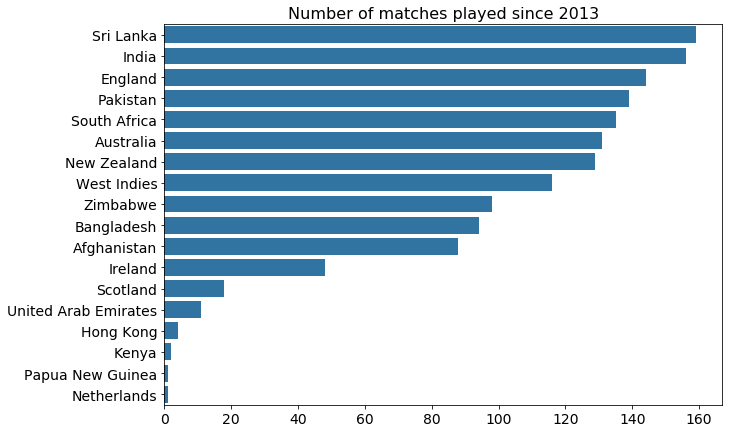

In [6]:
order = df_totals.country.value_counts().index
vis.setPlot(title="Number of matches played since 2013")
sb.countplot(data=df_totals, y='country', order=order, color=colour[0]);
plt.xlabel(None);
plt.ylabel(None);

There is a steady decline in the number of matches played per team since 2013 from Sri Lanka who have played the most. Hong Kong, Kenya, Netherlands, Papua New Guinea have all played less than 10 matches each so we might want to leave these teams out of our analysis when we start assessing averages.

At which grounds are the most matches played?

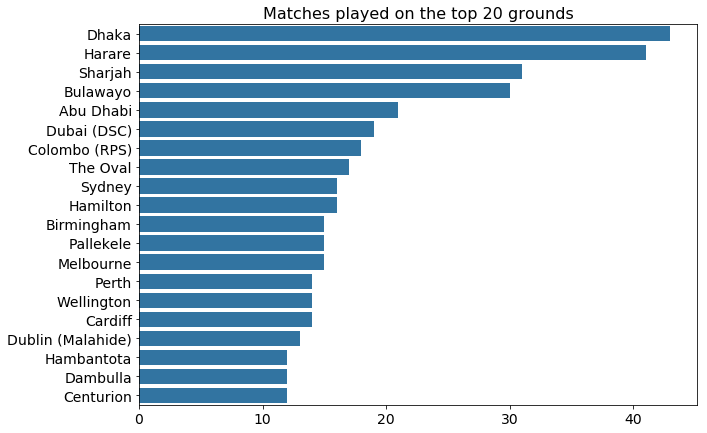

In [7]:
order = df_match.ground.value_counts().head(20).index
vis.setPlot(title="Matches played on the top 20 grounds")
sb.countplot(data=df_match, y='ground', order=order, color=colour[0]);
plt.xlabel(None);
plt.ylabel(None);

What is the breakdown of match results?

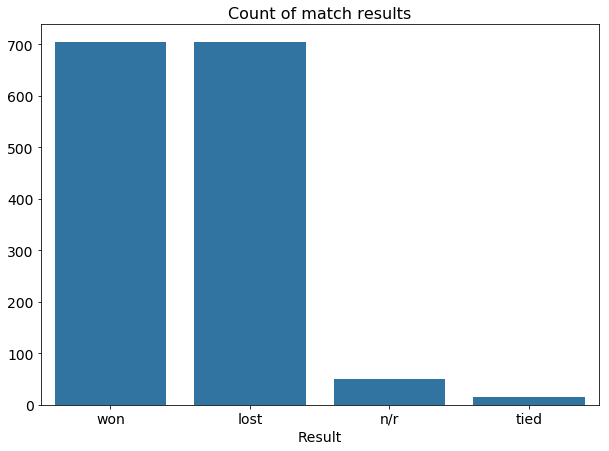

In [8]:
order = df_totals.result.value_counts().index

vis.setPlot(title="Count of match results")
sb.countplot(df_totals.result, order=order, color=colour[0]);
plt.xlabel("Result");
plt.ylabel(None);

As expected, there is an equivalent amount of matches won and lost because each match is represented here by 2 rows of data. There is a significant number of matches which do not have a result. These are likely due to weather preventing play so we might want to ignore these values later on.

In [9]:
df_totals.describe()

,match_id,score_total,wickets,overs,rpo,result_margin
count,1474.000000,1456.000000,1474.000000,1474.000000,1456.000000,1408.000000
mean,3720.238806,236.093407,7.297151,43.120692,5.386745,41.725852
std,238.129495,70.853138,2.774122,10.244894,1.169416,54.284178
min,3315.000000,8.000000,0.000000,0.000000,2.130000,1.000000
25%,3515.000000,191.000000,5.000000,40.025000,4.600000,6.000000
50%,3715.000000,240.000000,8.000000,48.000000,5.320000,9.000000
75%,3922.000000,283.000000,10.000000,50.000000,6.060000,68.000000
max,4140.000000,481.000000,10.000000,50.000000,14.160000,275.000000


The minimum values have some surprisingly low values which could be outliers in the data, particularly a score of 8 runs and innings length of 0 overs. Lets have a closer look at these.

In [10]:
df_totals.sort_values(by='score_total').head(12)

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method
966,3750,2016-06-19,South Africa,lost,1st,Australia,8.0,0,1.0,8.00,n/r,NaN,NaN
533,3432,2013-11-10,New Zealand,won,2nd,Sri Lanka,13.0,1,4.2,3.00,n/r,NaN,NaN
384,3324,2013-01-20,Sri Lanka,lost,2nd,Australia,14.0,0,3.2,4.20,n/r,NaN,NaN
977,3755,2016-06-26,England,won,2nd,Sri Lanka,16.0,1,4.0,4.00,n/r,NaN,NaN
1189,3913,2017-09-21,England,lost,1st,West Indies,21.0,0,2.2,9.00,n/r,NaN,NaN
512,3422,2013-10-23,India,won,2nd,Australia,27.0,0,4.1,6.48,n/r,NaN,NaN
424,3351,2013-03-25,Sri Lanka,lost,1st,Bangladesh,33.0,0,5.0,6.60,n/r,NaN,NaN
1373,4070,2018-11-11,New Zealand,lost,2nd,Pakistan,35.0,1,6.5,5.12,n/r,NaN,NaN
446,3369,2013-06-12,New Zealand,lost,2nd,Australia,51.0,2,15.0,3.40,n/r,NaN,NaN
1129,3876,2017-06-02,Australia,lost,2nd,New Zealand,53.0,3,9.0,5.88,n/r,NaN,NaN


The lowest 10 scores are all associated with n/r results. Lets remove these n/r results from the dataset since we do not know the reason behind them, they may impact on our statistics and they are less interesting for analysis.

In [11]:
df_totals = df_totals[df_totals.result != 'n/r']

### Distributions of Qantitative variables
Here we'll start by looking into the distributions of each of our quantitivative variables.
- `score_total`: technically the score in each match is discrete, since it is impossible to score a fraction of a run. Practically however, it will be easier to assess as a continuous to view the distribution.
- `overs`: this tells us how long each batting innings lasted in overs. Similarly, this is a discrete variable but for practicality we'll handle as a continuous variable. We need to be cautious because whilst the overs are often given with a decimal value, this value does not correspond to a fraction of an over but the number of balls bowled in that over. For example: 48.5 refers to 48 complete overs plus 5 balls as a pose to half an over. The maximum decimal possible is 48.5, since 48.6 == 49.0. 
- `rpo`: runs per over can also be treated as continuous.
- `wickets`: can only take integer values between 0-10 and there is discrete and we will treat as such.
- `result_margin` tells us winning margin. There are multiple ways of winning in cricket: by **X** runs if your opponents fail to reach your score, or by wickets if you reach the score that your opponets set with __X__ wickets remaining. These methods are documented in `result_method`.
- `start_date` will be usefull in looking at the number of matches played per year, month and season.
***
#### Score distribution
What shape distribution does `score_total` total have?

In [12]:
import importlib
importlib.reload(vis)
        

<module 'visualization.visualize' from '/home/ding/coding/machine_learning/ODI_cricket/src/visualization/visualize.py'>

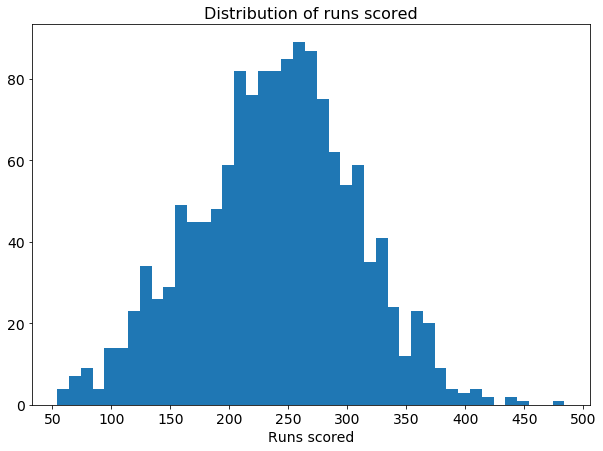

In [13]:
bins = vis.bins(df_totals, 'score_total', step=10)
ticks = np.arange(50,501,50)
labels = vis.tickLabels(ticks)

vis.setPlot(title="Distribution of runs scored", xlabel="Runs scored")

plt.hist(df_totals.score_total, bins=bins, color=colour[0]);
plt.xticks(ticks,labels);

The distribution is normal with marginal left skew and a maximum peak at 255 runs scored.

Are there any outliers in the `score_total` distribution?

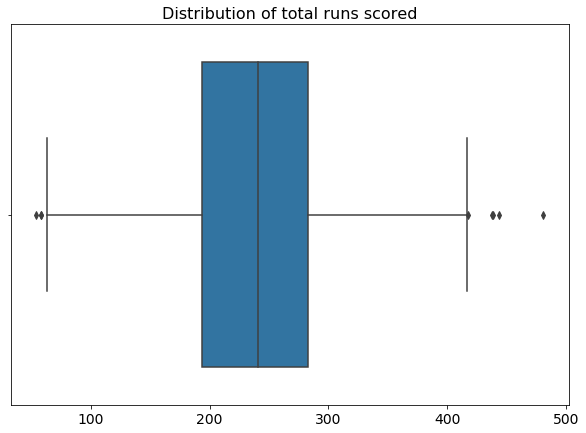

In [14]:
vis.setPlot(title="Distribution of total runs scored")
sb.boxplot(df_totals.score_total, color=colour[0]);
plt.xlabel(None);

Considering outliers as points which lie 1.5 times above or below the interquartile range, there are 2 outliers below the first quartile and 4 outliers that lie above the third quartile.

#### Runs per over distribution
What is the shape of the distribution of `rpo`?

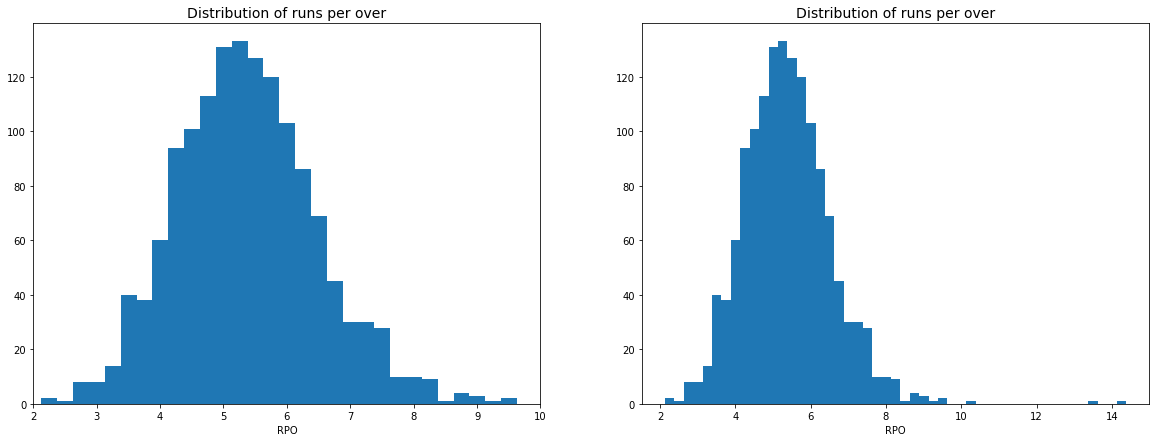

In [15]:
bins = vis.bins(df_totals,'rpo',step=0.25)

plt.figure(figsize=[20,7])
plt.subplot(1,2,1);
plt.hist(df_totals.rpo, bins=bins);
plt.xlim(2,10)
plt.title("Distribution of runs per over", fontsize=14);
plt.xlabel("RPO");

plt.subplot(1,2,2);
plt.hist(df_totals.rpo, bins=bins);
plt.title("Distribution of runs per over", fontsize=14);
plt.xlabel("RPO");


Run rate (rpo) has a general normal distribution centred around 5.3 runs per over. There is a small right skew in the data created by some outliers at 13 and 14 runs per over, which is quite exceptional. Both of these are scored by New Zealand, I expect Brendon McCullum might have had something to do with it.

Are there any outliers in the `rpo` distribution?

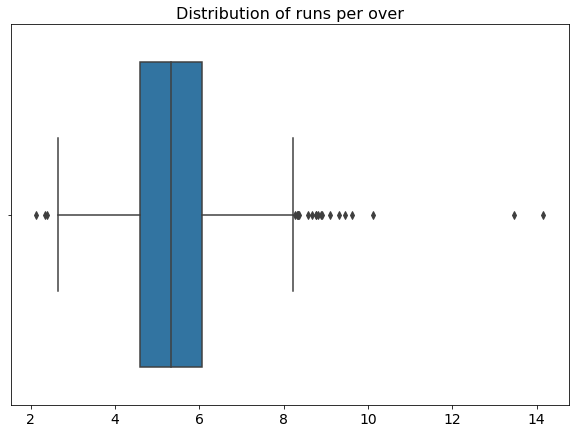

In [16]:
vis.setPlot(title="Distribution of runs per over")
sb.boxplot(df_totals.rpo, color=colour[0]);
plt.xlabel(None);

There are a large number outliers that lie above the 3rd quartile, and 3 outliers that lie below the first. This supports the observation that the data is positively skewed.

#### Distribution of winning margin
To properly assess this variable we need to sepearte by the `result_method`. Remember, we are treating runs as a continuos variable and wickets as disrete so we will plot a histogram and bar char.

In [17]:
runs = df_totals.query('result_method == "runs"')
wickets = df_totals.query('result_method == "wickets"')

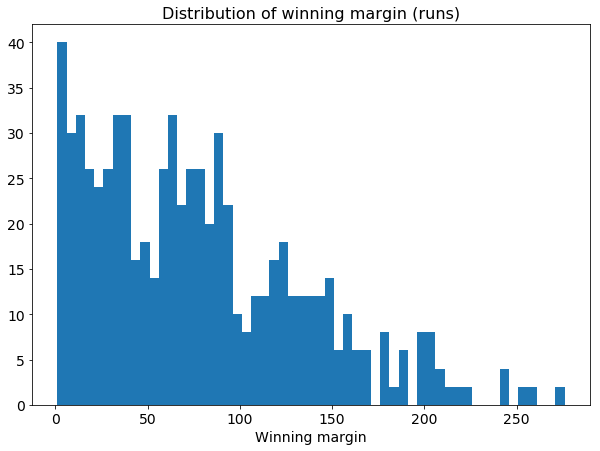

In [18]:
bins = vis.bins(runs, 'result_margin', step=5)

vis.setPlot(title="Distribution of winning margin (runs)", xlabel="Winning margin")
plt.hist(runs.result_margin, bins=bins, color=colour[0]);

The distribution of winning margin by runs is heavily positively skewed and has a number of peaks throughout the distribution. The highest peak is clustered in the first bin (0-5 runs).

What does the distribution of winning margin by wickets look like? We will consider this as a discrete distribution since it is only possible to win by 0-10 wickets.

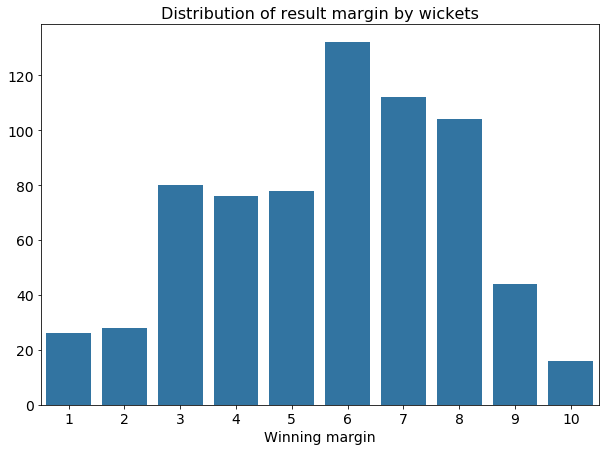

In [19]:
labels = np.arange(1,11,1)

vis.setPlot(title="Distribution of result margin by wickets")
sb.countplot(data=wickets, x='result_margin', color=colour[0]);
plt.xlabel("Winning margin");
plt.ylabel(None);
plt.xticks(labels-1, labels);

The distrbutions for each winning method are very different in nature. The winning margin by runs is very widely spread and heavily skewed to the right and multimodal in nature. Most matches are won by less than 100 runs. <br> <br>The winning margin by wickets has a roughly normal distribution with the most common winning margain being 6 wickets, and the least common being 1 and 10 wickets. 

#### Distribution of overs bowled
What is the distribution of overs bowled per match innings?

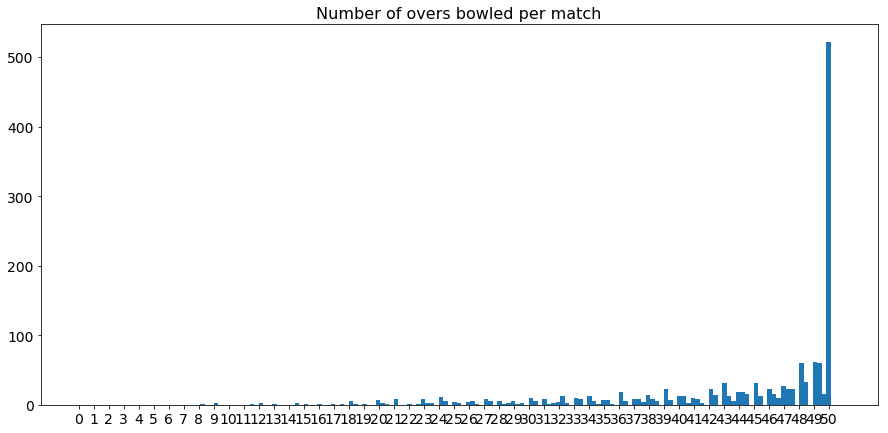

In [20]:
bins=np.arange(0,51,0.3)
ticks=np.arange(0,51,1)

vis.setPlot(title="Number of overs bowled per match", figsize=[15,7])
plt.hist(data=df_totals, x='overs', bins=bins);
plt.xticks(ticks,ticks);

The distribution of overs bowled is highly left skewed with the largest peak at 50 overs, occuring more than 400 times more than any other values. This can be expected, and tells us that most batting innings complete all 50 overs.

#### Distribution of wickets
This tells us how many wickets the batting team lost during their innings. 

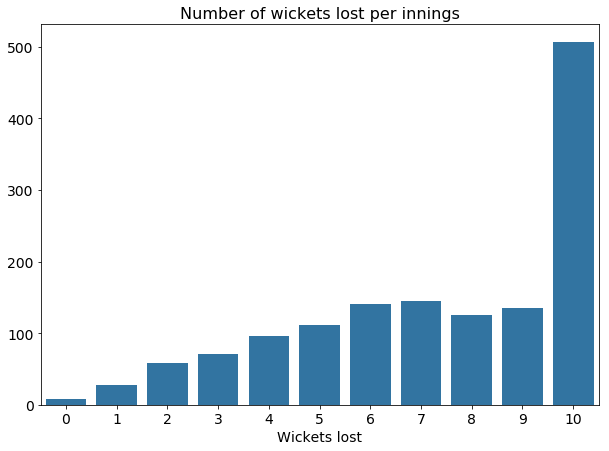

In [21]:
vis.setPlot(title="Number of wickets lost per innings");
sb.countplot(x = df_totals.wickets, color=colour[0]);
plt.ylabel(None);
plt.xlabel("Wickets lost");

Analysing the number of wickets taken per match gives a potentially curious result. 10 wickets are taken in 529 matches, 300 more than any other value of wickets taken. We previously saw that the majority of batting innings reach the 50 over mark, and therefore lose less than 10 wickets which contradicts what we are seeing here. <br><br>
This could be explained by the fact that a team can be bowled out during any over within the 50 overs and therefore is spread widely. Similarly, all of the innings that reach the 50 over mark have the number of wickets taken spread across 0-9 wickets taken. Lets group the data into binary groupings: "not out" and "all out", "50 overs" and "< 50 overs"

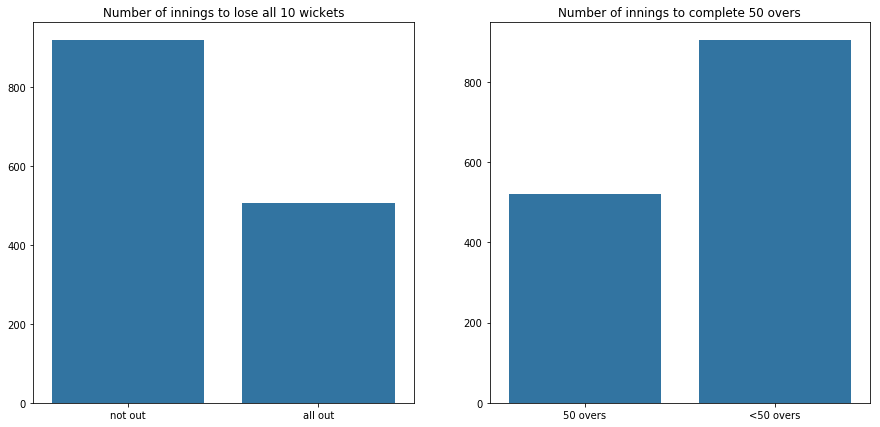

In [22]:
y = [(df_totals.wickets!=10).sum(), (df_totals.wickets==10).sum()]
x = ['not out','all out']

plt.subplots(1,2, sharey=True, figsize=[15,7])
plt.subplot(1,2,1);
sb.barplot(x = x, y=y, color=colour[0]);
plt.title("Number of innings to lose all 10 wickets");

y = [(df_totals.overs!=50).sum(), (df_totals.overs==50).sum()][::-1]
x = ['<50 overs','50 overs'][::-1]

plt.subplot(1,2,2);
sb.barplot(x = x, y=y, color=colour[0]);
plt.title("Number of innings to complete 50 overs");

The binary graphs show an interesting trend. The number of innings to reach 50 overs does not correspond to the number of innings where a team lost 10 wickets. This is because there are 451 successful run chases where a team batting second reaches the total set by the other team and therefore bringing and end to the game before 50 overs are reached. 

The chart below tells us that the coin toss was won and lost exactly 50% of the time which is, of course, to be expected because every win should have a corresponding loss, but confirms that our data entries for this variable are valid.

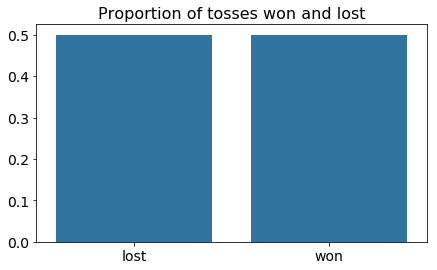

In [23]:
props=df_totals.groupby('toss').count()['match_id'].values / df_totals.shape[0]
x = df_totals.groupby('toss').count()['match_id'].index.values

vis.setPlot(title="Proportion of tosses won and lost", figsize=[7,4])
sb.barplot(x=x, y=props, color=colour[0]);

#### Matches played per year
Lets look into the distribution of matches played per year.

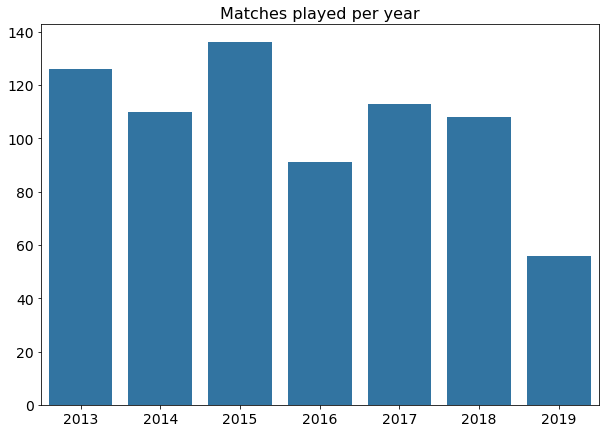

In [24]:
match_years = df_match.groupby(df_match.start_date.dt.year).count()['match_id']

vis.setPlot(title="Matches played per year")
sb.barplot(x=match_years.index.values, y=match_years.values, color=colour[0]);

2015 has the most matches played, which is the year of the previous ODI cricket world cup. 2019 has the lowest 
which also makes sense since we only have data until 2019-05-19.
***
#### Matches played per month
Lets look at the number of matches played per month.

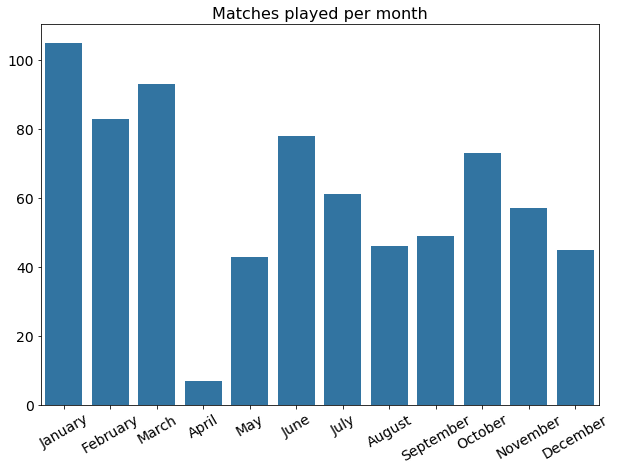

In [25]:
match_months = df_match.groupby(df_match.start_date.dt.month).count()['match_id']

vis.setPlot(title="Matches played per month")
sb.barplot(x=match_months.index.values, y=match_months.values, color=colour[0]);
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='30');

There is an oddly small amount of matches that are played in April, perhaps this could mark the end of the season in Asian and Australasian countries and is before the season starts elsewhere in the world.

#### Matches played by quarter
Finally lets look at the number of matches played per quarter.

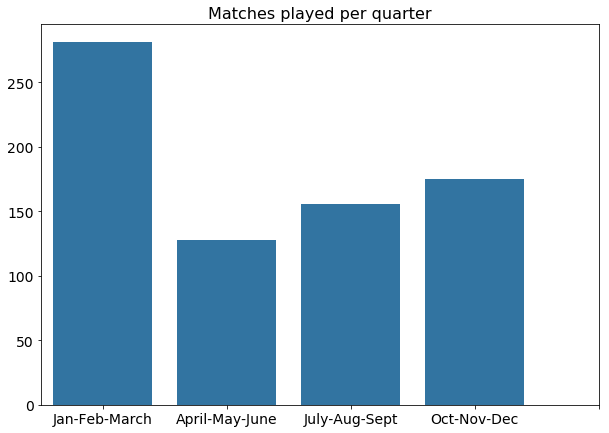

In [26]:
match_quart = df_match.groupby(df_match.start_date.dt.quarter).count()['match_id']
labels = ['Jan-Feb-March', 'April-May-June', 'July-Aug-Sept', 'Oct-Nov-Dec']

vis.setPlot(title="Matches played per quarter");
sb.barplot(x=match_quart.index.values, y=match_quart.values, color=sb.color_palette()[0]);
plt.xticks(np.arange(0,5,1), labels);

Most matches are played when it is winter winter in the northern hemisphere. This is a likely result of many matches being played in India and the surrounding countries when the weather is less hot than in the heights of summer. 

## Bivariate Analysis
Here we will investigate the relationships that exist between some of our variables. In order to answer most of the questions posed in the introduction we'll need to analyse the relationship between country and the other variables. We made country a categorical variable earlier in preparation for this. <br><br>
We'll start with the key question, who wins the most matches? We'll answer this based on the proportion of matches won.

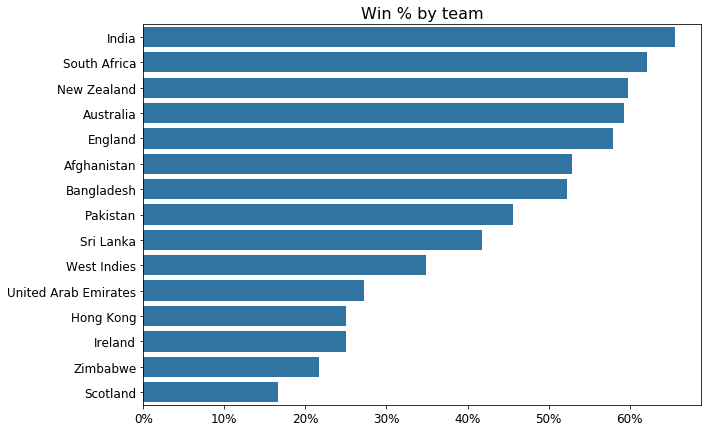

In [27]:
# Calculate win proportions per country
matches_played = df_totals.country.value_counts()
win_counts = df_totals.query('result == "won"').groupby('country').count()['match_id'].sort_values(ascending=False)
win_prop = (win_counts/matches_played).sort_values(ascending=False).head(15)

order= win_prop.index

ticks = np.arange(0,0.7,0.10)
labels = vis.tickLabels(ticks, multi=100, pcnt=True, f=0)

vis.setPlot(title="Win % by team")
sb.barplot(x=win_prop.values, y=win_prop.index, color=colour[0], order=order);
plt.xticks(ticks, labels, fontsize=12);
plt.yticks(fontsize=12);

India have the highest win percentage of all countries, winning 65% of their matches. But who is the most successful team on English grounds?

#### Success on English grounds
First, we need to merge the `ground` data from `df_match` into `df_totals` to use as a filter.

In [28]:
df_totals = df_totals.merge(df_match[['match_id','ground']], on='match_id')

In [29]:
importlib.reload(vis)

<module 'visualization.visualize' from '/home/ding/coding/machine_learning/ODI_cricket/src/visualization/visualize.py'>

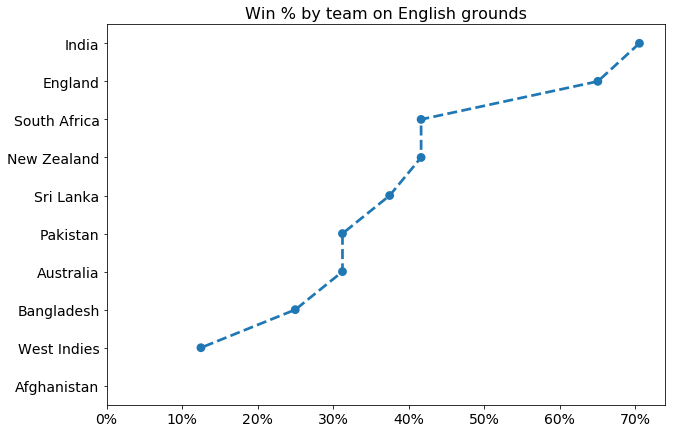

In [30]:
english_grounds = ['The Oval', 'Birmingham', 'Cardiff', 'Nottingham', 'Southampton', 
                   'Leeds', "Lord's", 'Manchester', 'Chester-le-Street', 'Bristol', 'East London']
cup_countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', "New Zealand", 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

# Create world cup df
df_wc = df_totals[(df_totals.ground.isin(english_grounds))&(df_totals.country.isin(cup_countries))]

# Caluclate win proportions
matches_played = df_wc.country.value_counts()[cup_countries]

win_counts = df_wc[df_wc.result=="won"].groupby('country').count()\
                        ['match_id'][cup_countries].sort_values(ascending=False)

win_prop = (win_counts/matches_played).sort_values(ascending=False)
order=win_prop.index

vis.setPlot(title="Win % by team on English grounds")
sb.pointplot(x=win_prop.values, y=win_prop.index, order=order, linestyles='--');

ticks = np.arange(0,0.8,0.10)
labels = vis.tickLabels(ticks, pcnt=True, multi=100)

plt.xticks(ticks, labels);

India also have the highest win percentage on English grounds, showing why they were strongly favoured going into the tournament. England also have a very strong win percentage on home soil, with both countries winning over 20% more than the next closest rivals in South Africa.

There are no records of Afghanistan playing matches in England in the dataset so they will enter the World Cup as somewhat of a mystery team.

Lets look at which teams are most dangerous with the ball and take the most wickets, as well as the team that loses the most wickets.

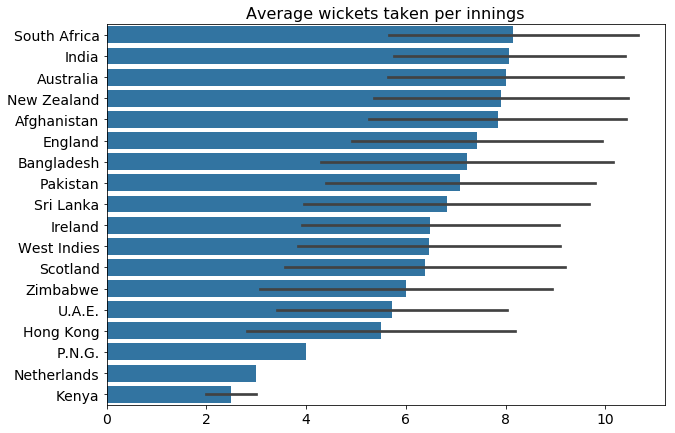

In [31]:
vis.setPlot(title="Average wickets taken per innings")
order = df_totals.groupby('opposition').mean()['wickets'].sort_values(ascending=False).index
sb.barplot(data=df_totals, x='wickets', y='opposition', color=colour[0], order=order, ci='sd');
plt.ylabel(None);
plt.xlabel(None);

There is very little separation between average wickets taken per innings between the top teams, and each team has a fairly large spread standard deviation of the mean.

Lets see who takes the most wickets in English grounds to see if there is a more significant separation.

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


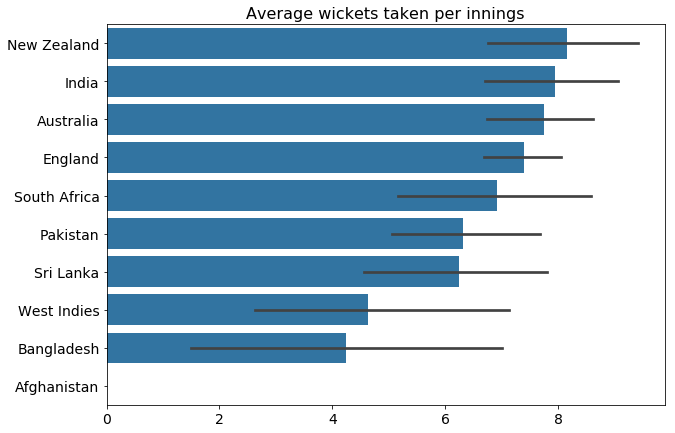

In [32]:
vis.setPlot(title="Average wickets taken per innings")

avg_wickets = df_wc.groupby('opposition').mean()['wickets'].sort_values(ascending=False)[cup_countries]

order = avg_wickets.sort_values(ascending=False).index

sb.barplot(data=df_wc, x='wickets', y='opposition', color=colour[0], order=order, ci=95);
plt.ylabel(None);
plt.xlabel(None);

Again, there is very little to separate the top teams on their average wickets taken per innings and due to the large spread it is difficult to draw any meaningful conclusions from the statistic. For this reason we'll move on to look at the distributions of other variables in the dataset.

#### Result Margins
What are the distributions of winnins margins by team?

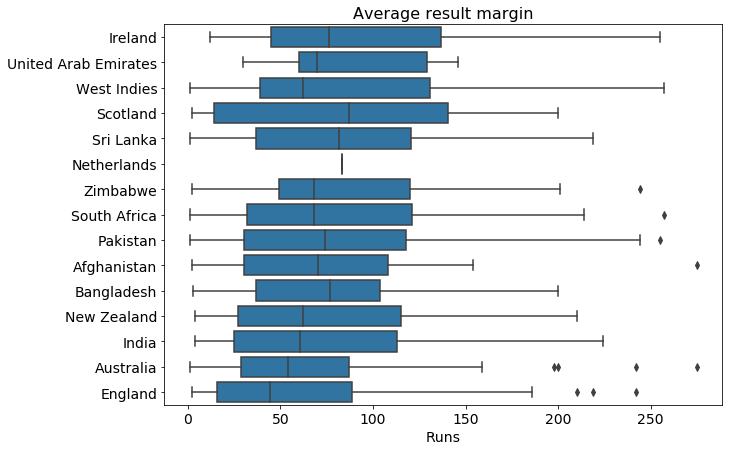

In [33]:
order = runs.groupby('country').mean()['result_margin'].sort_values(ascending=False).head(15).index

vis.setPlot(title="Average result margin")
sb.boxplot(data = runs, x='result_margin', y='country', order=order, color=colour[0]);
plt.ylabel(None);
plt.xlabel("Runs");

The result margin for each team is skewed to the right with all outliers above 200 run win margin, which aligns with our observations of the overal result margin made earlier.

Matches in which Ireland are involved in have the highest result margin in terms of runs. This however does not tell us whether a team has won or lost by that margin, for that we need to include the `result` variable. We can see the data has a large spread for most countries. More on this later.

### Scores and Run Rates 
Lets invesitage the relationships between `score_totals` and `rpo` with some other variables. Since we'll mostly be dealing with averages here it makes sense to ignore the teams that have played less than 10 matches each, keeping the rows in which they are an opponent only. `country` is categorical type, so to avoid plotting empty panels we'll temporarilly convert this back to object type.
***
#### Score vs rpo
Lets starts with the relationship between `score_totals` and `rpo`. We might expect this to be fairly linear since `rpo` is calculated using the `score_total`.

In [34]:
# Get countries that have played more than 10 matches
countries10 = df_totals.country.value_counts()[df_totals.country.value_counts() > 10].index
df_temp = df_totals[df_totals.country.isin(countries10)]
df_temp.country = df_temp.country.astype(object)
df_temp.opposition = df_temp.opposition.astype(object)

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


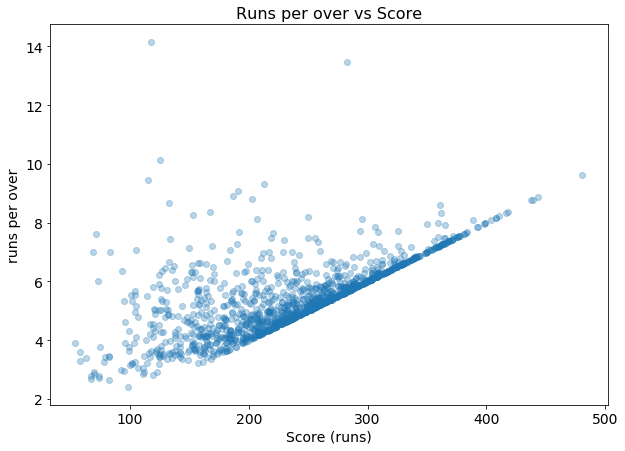

In [35]:
vis.setPlot(title="Runs per over vs Score")
sb.regplot(data=df_temp, y='rpo', x='score_total', scatter_kws={'alpha':0.3}, fit_reg=False);
plt.xlabel("Score (runs)");
plt.ylabel('runs per over');

This chart shows some fairly interesting trends. Scores lower than 200 seem to have a very weak positive correlation with rpo. This positive correlation increases in strength as the numbers of runs scored increases, giving rise to a hockey stick shape. There is a dense line of points which form a baseline with no points below that line. Scores below this line are impossible to achieve in 50 overs with that value of rpo.<br>

Lets enhance this observation visually by plotting seperate series either side of the 200 run total.

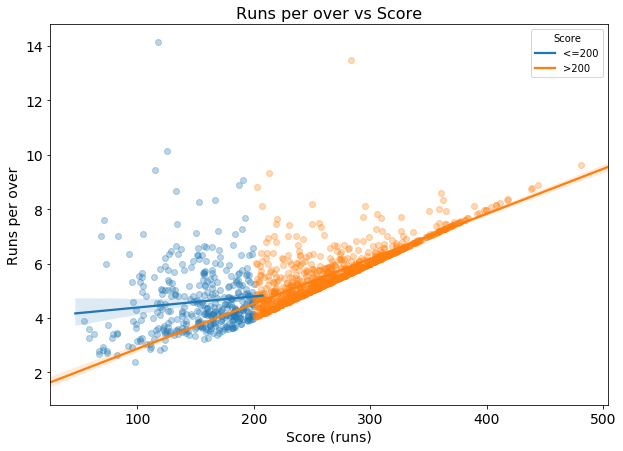

In [36]:
vis.setPlot(title="Runs per over vs Score")

sb.regplot(data=df_temp[df_temp.score_total <= 200], y='rpo', x='score_total', scatter_kws={'alpha':0.3});
sb.regplot(data=df_temp[df_temp.score_total > 200], y='rpo', x='score_total', scatter_kws={'alpha':0.3});

plt.legend(title="Score",labels=['<=200', '>200']);
plt.xlabel("Score (runs)");
plt.ylabel("Runs per over");

With the data separated we can clearly see how the regression model becomes stronger and more positive for scores greater than 200 runs.

What happens when we plot the change in pearsons coefficient as the score increases?

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


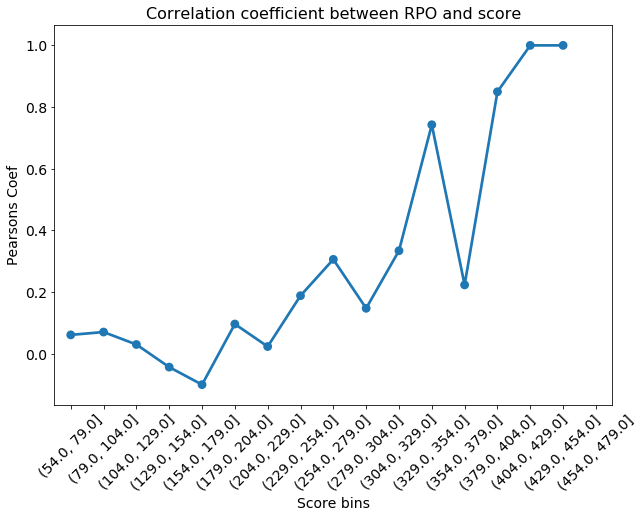

In [37]:
# Create score bins
bins = np.arange(df_temp.score_total.min(),df_temp.score_total.max()+1,25)

# Cut the data set into the score bins
df_temp['bin_score'] = pd.cut(df_temp.score_total, bins=bins)
bin_scores = df_temp.groupby('bin_score').count().index

# Calulate pearsons coefficient for each score bin
pearson = []
for b in bin_scores:
    df = df_temp[df_temp.bin_score == b]
    pearson.append(df.score_total.corr(df.rpo))

x=np.arange(0,len(pearson),1)

vis.setPlot(title="Correlation coefficient between RPO and score")
sb.pointplot(x=x,y=pearson);
plt.xticks(x, bin_scores, rotation='45');
plt.xlabel("Score bins");
plt.ylabel("Pearsons Coef");

The pearson's coefficient generally increases as the score bins increase in value, supporting the observations we have previously made. There is a sharp reduction in correlation strength for the score bin 329-354 which corresponds with a cluster of points we can see in the scatter plots above.

#### Score Averages by Country
Lets investigate the average scores and rpo's look like for each country?

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


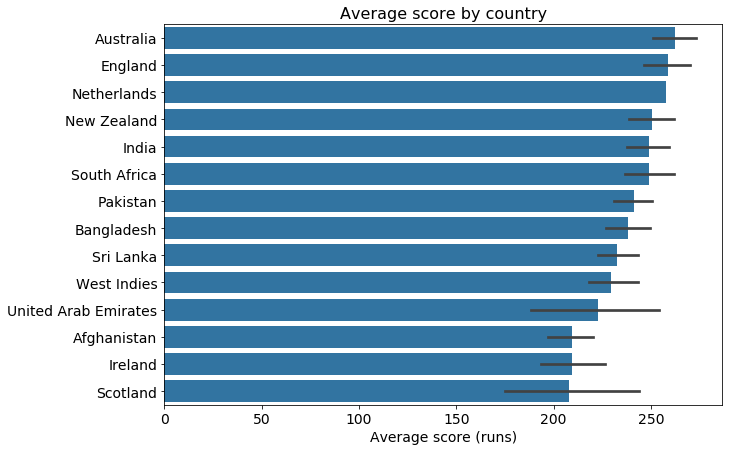

In [38]:
order = df_totals.groupby('country').score_total.mean().sort_values(ascending=False).head(14).index

vis.setPlot(title="Average score by country")
sb.barplot(data = df_totals, x='score_total', y='country', order=order, color=colour[0], ci=95);
plt.ylabel(None);
plt.xlabel('Average score (runs)');

Australia score on average the most runs per innings, however there is very little that separates the top 9 teams, all of which will be competing in the World Cup. Afghanistan have the lowest average run rate of the World Cup countries, it is possible to reject a null hypothesis that states: "Afghanistan score on average the same amount of runs as the other World Cup countries" with 95% condifidence based on the data within the sample.

How do the average runs per over scored per team compare?

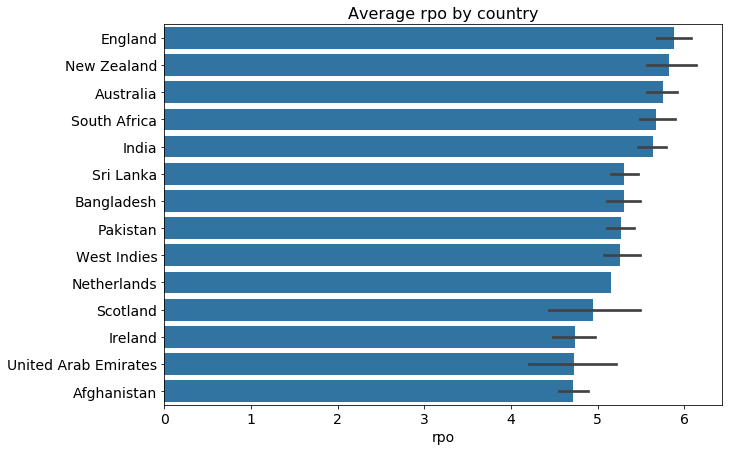

In [39]:
order = df_totals.groupby('country').rpo.mean().sort_values(ascending=False).head(14).index

vis.setPlot(title="Average rpo by country")
sb.barplot(data = df_totals, x='rpo', y='country', order=order, color=colour[0], ci=95);
plt.ylabel(None);

The average run rate seems to fall into 3 main clusters with England, New Zealand, Australia, South Africa and India forming a clear top 5, another group of 5 countries forming the intermediate group then the rest of the teams, which include Afghanistan. I'm most surprised by the position of the West Indies both charts given that they have the reputation of being an attacking team, one might expect them to have higher averages.

One interesting observation to be made is that India had the highest win percentage of any team, yet they sit 4th and 5th in their average score and rpo repsectively. This might suggest that their bowling attack is more sccessful at limiting the runs of their opponents than some of the other top teams. Although, given the overlap of  the 95% confidence intervals this is not conclusive.

Lets reassess both of these statistics when considering only the world cup teams performance on English grounds.

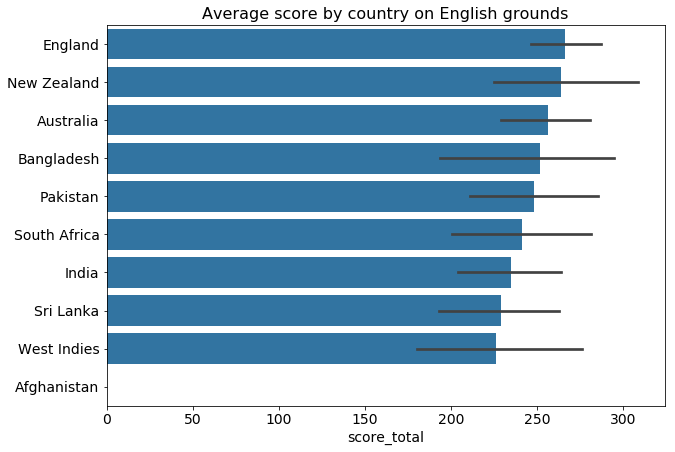

In [40]:
order = df_wc.groupby('country').score_total.mean()[cup_countries].sort_values(ascending=False).index

vis.setPlot(title="Average score by country on English grounds")
sb.barplot(data = df_wc, x='score_total', y='country', order=order, color=colour[0], ci=95);
plt.ylabel(None);

Here, India have the 6th highest scoring average on English grounds out of the 10 World Cup teams yet they have the highest win percentage on English grounds.

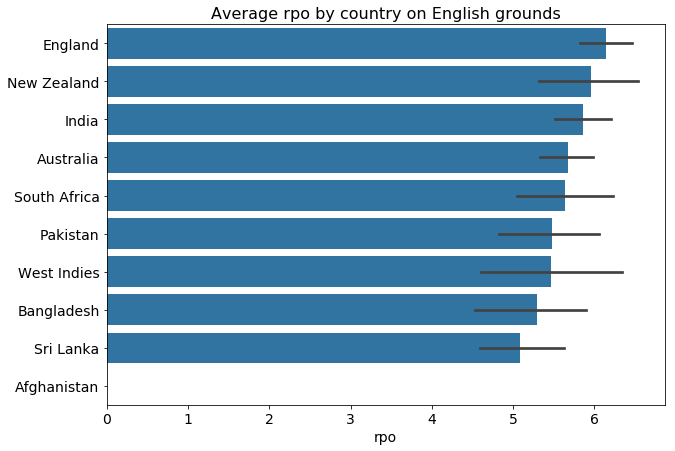

In [41]:
order = df_wc.groupby('country').rpo.mean()[cup_countries].sort_values(ascending=False).index

vis.setPlot(title="Average rpo by country on English grounds")
sb.barplot(data = df_wc, x='rpo', y='country', order=order, color=colour[0], ci=95);
plt.ylabel(None);

England have the highest scoring average and the highest average runs per over on English grounds.

I wonder what the average score of each teams opponents tells us about the quality of each countries bowling attack to limit the amount of runs conceded? To assess this we need to add an extra features `opponent_score` and `opponent_wickets` to the dataframe. We could calculate the statistics by grouping on `opponent`, but this would only allow us to make global comparisons between the average runs scored and conceded. Adding these features  enables us to assess the distribution of the difference in score and runs per over.

In [42]:
def opponentScore(df, idx_list):
    for i in idx_list[1:]:
        # Finding matching match id
        if df.loc[i,'match_id'] == df.loc[i-1,'match_id']:
            row = i-1
            # Import data from matching row
            df.loc[i,'opponent_score'] = df.loc[row, 'score_total']
            df.loc[i,'opponent_wickets'] = df.loc[row, 'wickets']
            df.loc[i,'opponent_rpo'] = df.loc[row, 'rpo']
        
    for i in idx_list[:-1]:
        # Finding matching match id
        if df.loc[i,'match_id'] == df.loc[i+1,'match_id']:
            row = i+1
            # Import data from matching row
            df.loc[i,'opponent_score'] = df.loc[row, 'score_total']
            df.loc[i,'opponent_wickets'] = df.loc[row, 'wickets']
            df.loc[i,'opponent_rpo'] = df.loc[row, 'rpo']


idx=df_totals.index
opponentScore(df_totals, idx)

# Create delta features for rpo and score
df_totals['delta_rpo'] = df_totals.rpo - df_totals.opponent_rpo
df_totals['delta_score'] = df_totals.score_total - df_totals.opponent_score

Now that we have engineered pur features, lets look at the distribution of score deltas per innings.

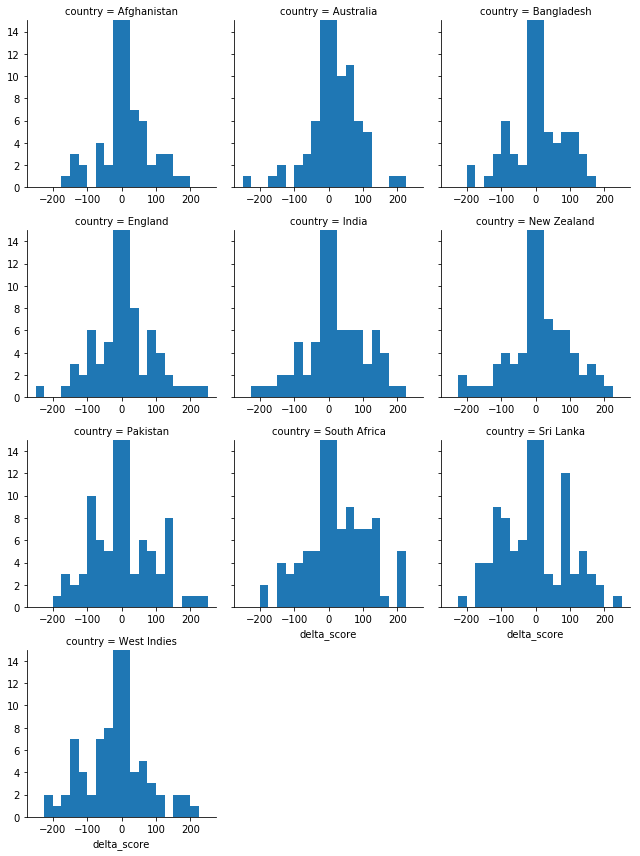

In [43]:
bins= np.arange(-250,251,25)
g=sb.FacetGrid(df_totals, col='country', col_wrap=3, sharex=False, col_order=cup_countries)
g.map(plt.hist, 'delta_score', bins=bins)
axs = g.axes
for ax in axs:
    ax.set_ylim((0,15));

All of the distributions above have a large peak around 0 runs. This is likely because all results in which the team batting second wins the match will have a maximum score delta of 6 runs because the game finishes when they catch their opponents score. To prevent these large peaks obscurring the distrbutions we've limited the y_axes.

Many of the distrbutions appear to be bimodal in nature, with peaks around +100 runs and - 100 runs. The distributions for South Africa, Australia, India and New Zealand are all left skewed, indicating that they generally score more runs than their opponents. 

Previously we saw that England had high average score and rpo. The normally distributed score delta here suggests that although they score a lot of runs, they also conceded alot of runs. India were surprisingly low scoring considering they had the highest win percentage. The negatively skewed distribution of score delta indicates that they are successful at limiting their opponents runs to win matches.

Lets look into the global average to see if this is reflected.

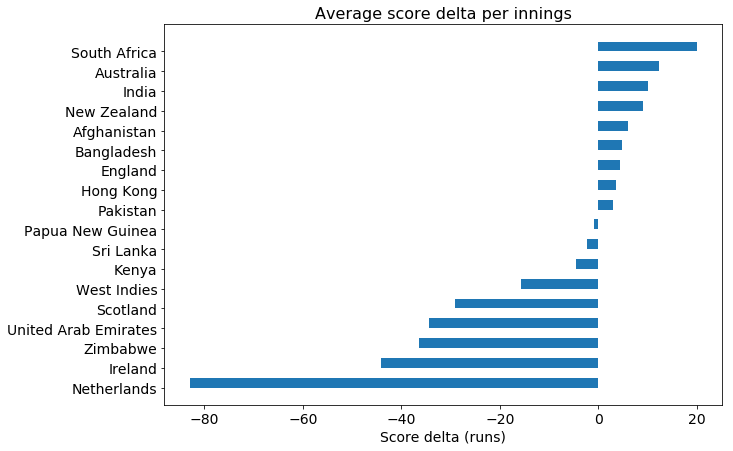

In [44]:
vis.setPlot(title="Average score delta per innings")

score_delt = df_totals.groupby('country').mean()['delta_score'].sort_values()

plt.barh(width=score_delt.values, y=score_delt.index, color=colour[0], height=0.5, align='edge');
plt.ylabel(None);
plt.xlabel("Score delta (runs)");

The top 4 countries who have the most positive score delta are South Africa, Australia, India and New Zealand as identified in the previous distributions. This can only be used as a measure of performance when teams bat first as a team batting second cannot amas a large score delta.

RPO delta might be a better metric for assessing a teams scoring success, lets look at that.

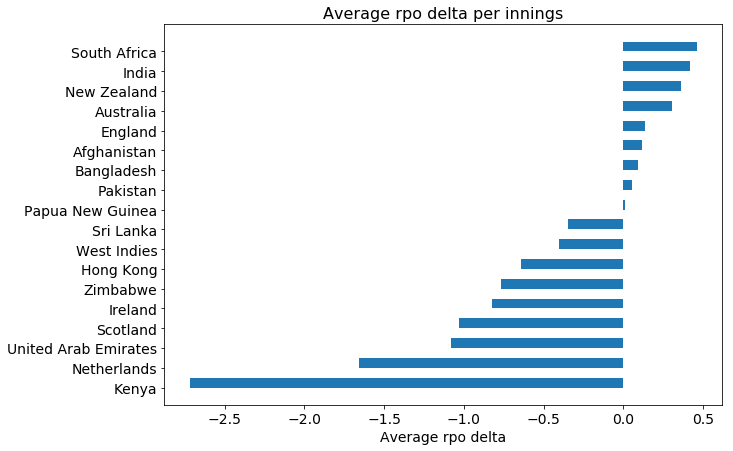

In [45]:
vis.setPlot(title="Average rpo delta per innings")

rpo_delt = df_totals.groupby('country').mean()['delta_rpo'].sort_values()

plt.barh(width=rpo_delt.values, y=rpo_delt.index, color=colour[0], height=0.5, align='edge');
plt.ylabel(None);
plt.xlabel("Average rpo delta");

The global rpo delta shows a similar pattern to that seen in the score delta. Lets look att he individual distributions.

#### Highest Score and Run Rates
What country has achieved the highest score in a single innings?

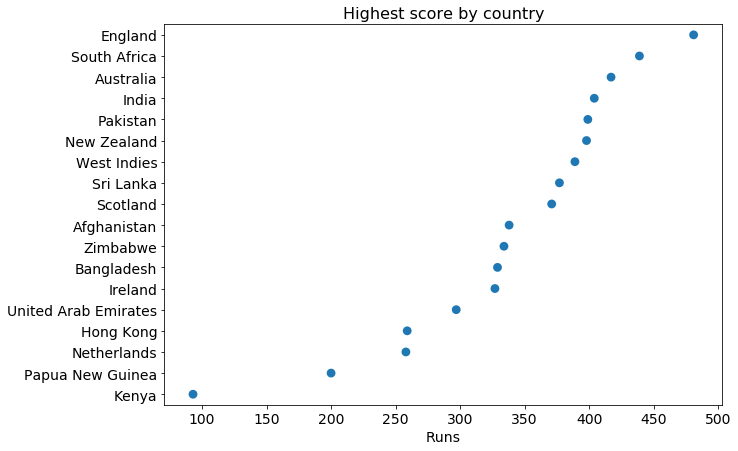

In [46]:
order = df_totals.groupby('country').score_total.max().sort_values(ascending=False).index
max_score = df_totals.groupby('country').score_total.max().sort_values(ascending=False).values

vis.setPlot(title="Highest score by country")
sb.pointplot(y=order, x=max_score, order=order, linestyles='');
plt.ylabel(None);
plt.xlabel("Runs");

England are the world record holders for the maximum score achieved in a 50 over innings with a quite incredible 481 runs scored in trent bridge in 2018. Kenya aren't a well know cricketing nation, which is apparent with their maximum score less than 100 runs.

Who has achieved the highest run rate in a single innings?

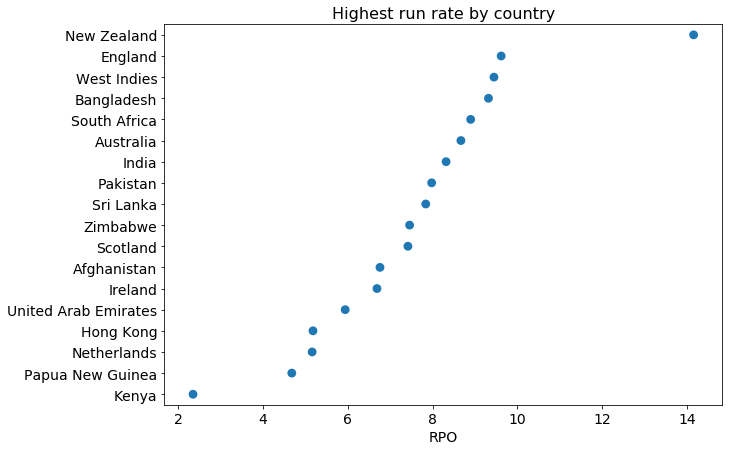

In [47]:
order = df_totals.groupby('country').rpo.max().sort_values(ascending=False).index
max_rpo = df_totals.groupby('country').rpo.max().sort_values(ascending=False).values

vis.setPlot(title="Highest run rate by country")
sb.pointplot(y=order, x=max_rpo, order=order, linestyles='');
plt.xlabel("RPO");
plt.ylabel("");

New Zealand are way out in front with a run rate over 14 runs per over! England are best of the rest and there is a fairly steady reduction in the maximum run rate achieved across the data set. Kenya are again in last place, having only played 1 match their average is the same as their maximum.

#### Score information vs time
How has the average score and rpo changed each year?

To inspect this we need to extract the years from the start date.

In [48]:
df_totals['year'] = df_totals.start_date.dt.year

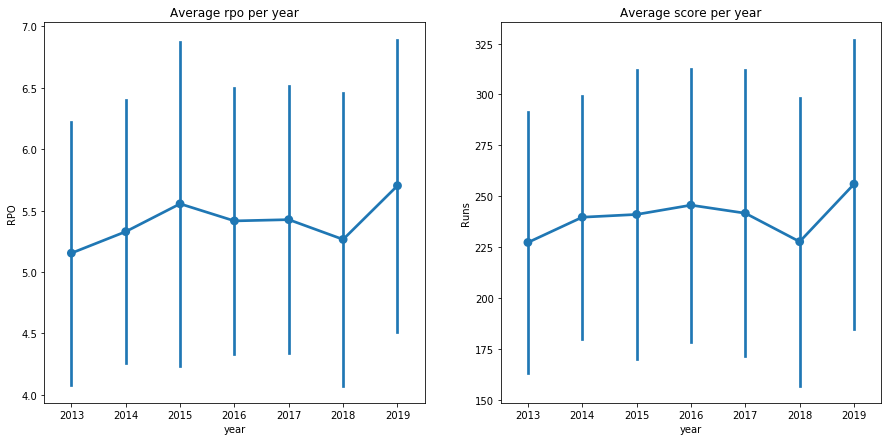

In [49]:
plt.subplots(1,2,figsize=[15,7])
plt.subplot(1,2,1)
sb.pointplot(data=df_totals, x='year', y='rpo', color=colour[0],ci='sd');
plt.title("Average rpo per year");
plt.ylabel("RPO");

plt.subplot(1,2,2)
sb.pointplot(data=df_totals, x='year', y='score_total', color=colour[0], ci='sd');
plt.title("Average score per year");
plt.ylabel("Runs");

The trends in runs per over and total score each year are strongly linked, and both have a large spread in the data. We can see that the average score per innings generally increases each year with a dip in 2018. The amount of matches played in 2019 so far is significantly less than in other years so could be more easily affected by outliers.

How does time of year affect the average score?

To assess this we'll need to extract the month data from start_date.

In [50]:
df_totals['month'] = df_totals.start_date.dt.month

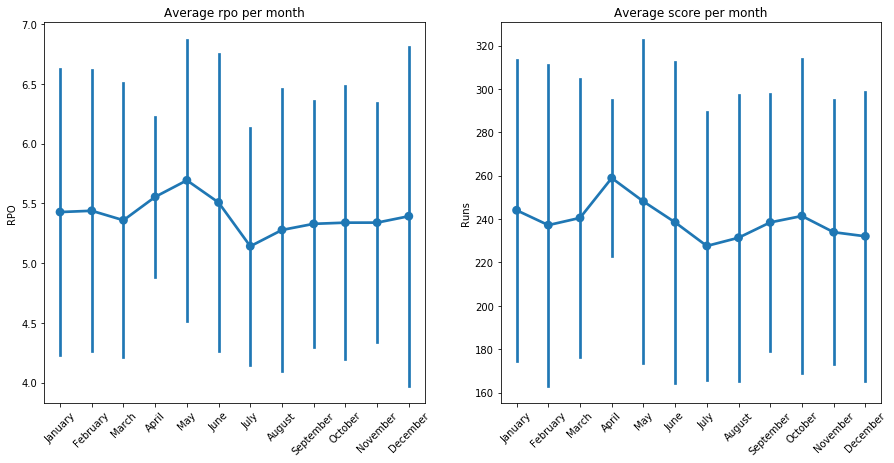

In [51]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
          'September', 'October','November', 'December']

plt.subplots(1,2,figsize=[15,7])
plt.subplot(1,2,1)
sb.pointplot(data=df_totals, x='month', y='rpo', color=colour[0],ci='sd');
plt.title("Average rpo per month");
plt.ylabel("RPO");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');
plt.xlabel(None);


plt.subplot(1,2,2)
sb.pointplot(data=df_totals, x='month', y='score_total', color=colour[0], ci='sd');
plt.title("Average score per month");
plt.ylabel("Runs");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');
plt.xlabel(None);

There is a small relative change in the average scores and rpo's each month. Each month has a large spread. April has the smallest spread because the number of matches played during April is much lower than in any other month.

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


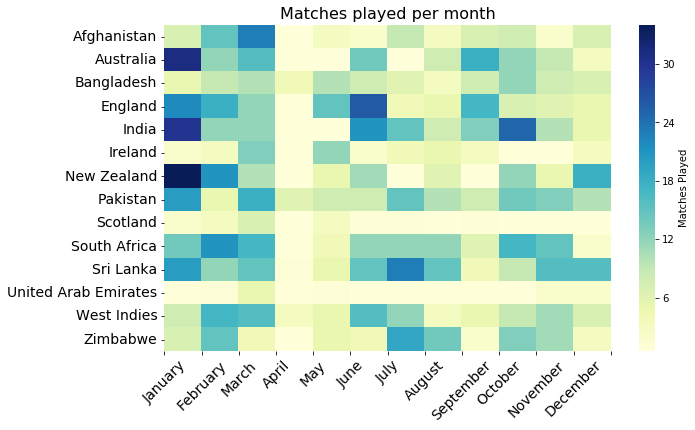

In [52]:
df_temp['month'] = df_temp.start_date.dt.month
df_temp['month'] = df_temp.month.astype('category')

grouped = df_temp.groupby(['country', 'month']).count()['match_id']
values = np.where(grouped.isnull(), 0, grouped)
values = values.reshape(14,12)

plt.figure(figsize=[10,6])
sb.heatmap(values, vmin=0.5, cmap='YlGnBu', cbar_kws={'label':'Matches Played'});

y_locs, y_labels = plt.yticks()
x_locs, x_labels = plt.xticks()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

plt.xticks(np.arange(0,13,1), months, rotation=45, fontsize=14);
plt.yticks(np.arange(0.5,14.5,1), grouped.index.levels[0], rotation=0, va='center', fontsize=14);
plt.title("Matches played per month", fontsize=16);


Bagladesh, Pakistan and the West Indies are the only teams who play any matches during April and they play a small number of matches. The official international cricket season in 2019 is May-September, perhaps this is the reason for so little matches being played in April.

# Remove Ground Averages?
#### World Cup Ground averages

In [53]:
df_temp = df_totals[df_totals.ground.isin(english_grounds)]

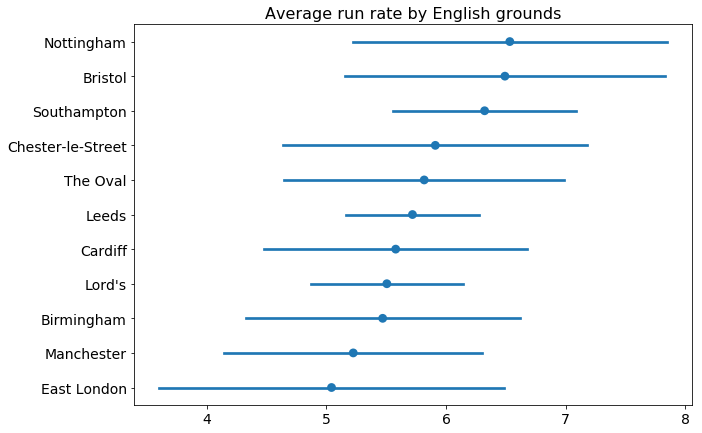

In [54]:
ground_rpo_avg = (df_temp.groupby('ground').rpo.mean()[english_grounds]).sort_values(ascending=False)

vis.setPlot();
sb.pointplot(data=df_temp, x='rpo', y='ground', order=ground_rpo_avg.index, ci='sd', linestyles='');
plt.title("Average run rate by English grounds", fontsize=16);
plt.ylabel("");
plt.xlabel(None);


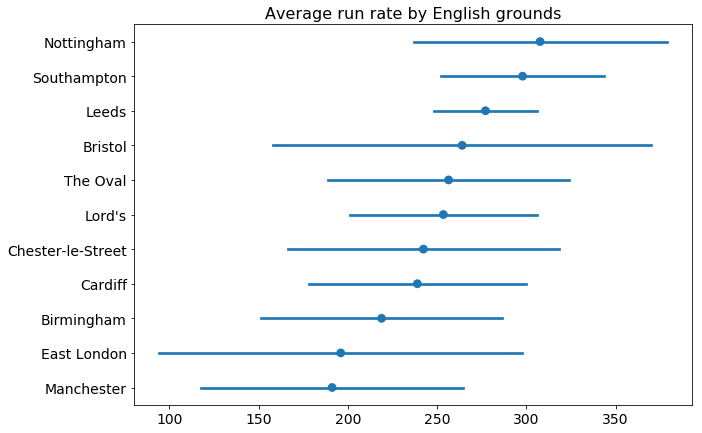

In [55]:
ground_rpo_avg = (df_temp.groupby('ground').score_total.mean()[english_grounds]).sort_values(ascending=False)

vis.setPlot();
sb.pointplot(data=df_temp, x='score_total', y='ground', order=ground_rpo_avg.index, ci='sd', linestyles='');
plt.title("Average run rate by English grounds", fontsize=16);
plt.ylabel("");
plt.xlabel(None);


In [56]:
df_totals[df_totals.ground == "Queenstown"]

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,...,result_margin,result_method,ground,opponent_score,opponent_wickets,opponent_rpo,delta_rpo,delta_score,year,month
552,3451,2014-01-01,West Indies,won,2nd,New Zealand,124.0,5,21.0,5.90,...,159.0,runs,Queenstown,283.0,4.0,13.47,-7.57,-159.0,2014,1
553,3451,2014-01-01,New Zealand,lost,1st,West Indies,283.0,4,21.0,13.47,...,159.0,runs,Queenstown,124.0,5.0,5.90,7.57,159.0,2014,1


The ground with the highest average runs per over is Queenstown, however, the only match to have been played there New Zealand achieved the highest run rate across the entire dataset. This is reflected in the standard deviation which is higher than any other ground in the top 25.

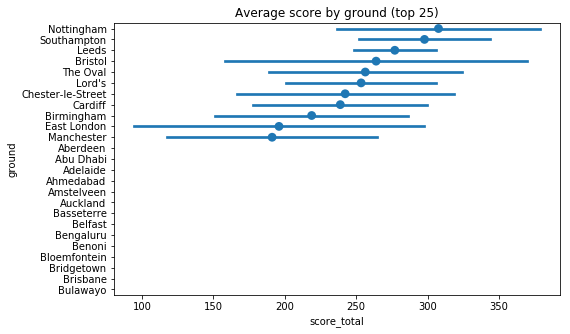

In [57]:
plt.figure(figsize=[8,5])
ground_score_avg = df_temp.groupby('ground').score_total.mean().sort_values(ascending=False).head(25)
sb.pointplot(data=df_temp, x='score_total', y='ground', order=ground_score_avg.index, ci='sd', linestyles='');
# plt.barh(width=ground_rpo_avg.values, y=ground_rpo_avg.index);
plt.title("Average score by ground (top 25)");

There is generally a much greater spread of data associated with the ground score averages than there is with the runs per over averages. It is possibale to achieve the same runs per over rate and finish with quite different scores due to some innings being shortened due to a team being bowled out before 50 overs are reach, a team catching the other teams score before 50 overs and sometimes matches are shortened due to bad weather. 

#### Score vs Result
Lets look at the relationship between total score and the match result and see if there is a threshold.

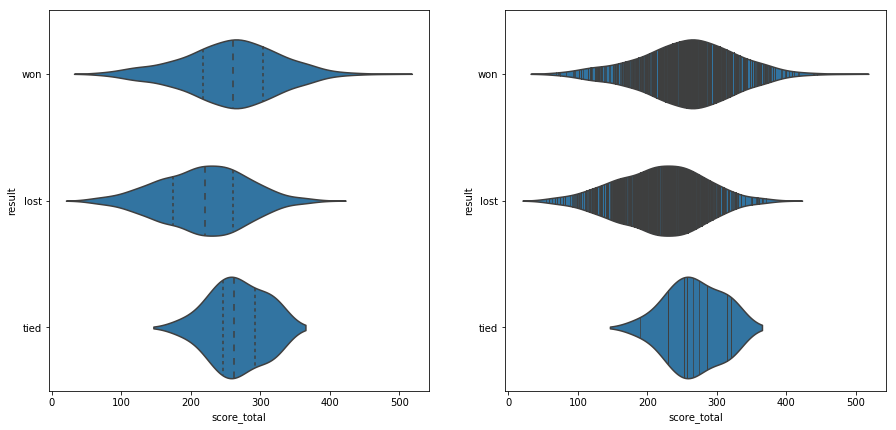

In [58]:
plt.subplots(figsize=[15,7], sharey=True)
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="result", x='score_total', color=colour[0], 
              inner='quartile', order =['won','lost','tied']);

plt.subplot(1,2,2)
sb.violinplot(data=df_totals, y="result", x='score_total', color=colour[0], 
              inner='stick', order =['won','lost','tied']);

The distribution of scores that ended in a win are most widely spread but also most normally distributed. Losing scores have a left skew. Scores that results in a tie have the least amount of spread. There are far fewer examples of a tied result as seen in the violin-stick plot which might explain the tighter spread.

#### Score vs Batting Order and Coin Toss
Lets look at the relationship between total score and the batting order to see if there is any benefit of batting 1st or 2nd.

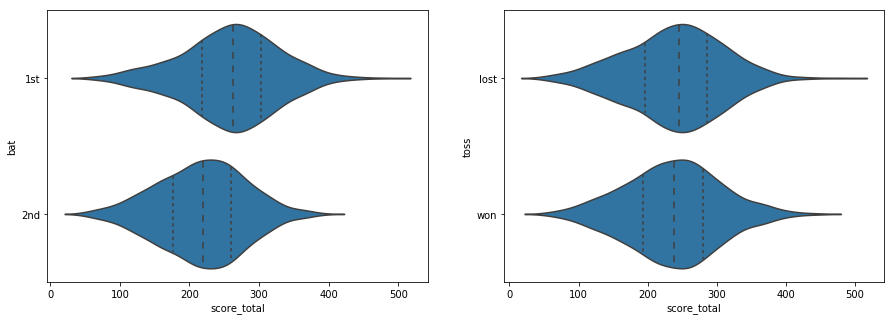

In [59]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="bat", x='score_total', color=colour[0], inner='quartile', order=['1st','2nd']);
plt.subplot(1,2,2)
sb.violinplot(data=df_totals, y="toss", x='score_total', color=colour[0], inner='quartile');


- Teams batting 1st appear to generally score more runs. The distributions have very similar spread and are separated by around 50 runs.
- The coin toss appears to have very little affect on the innings score.<br>
Lets see if this score advantage when batting 1st is reflected in the number of matches won.

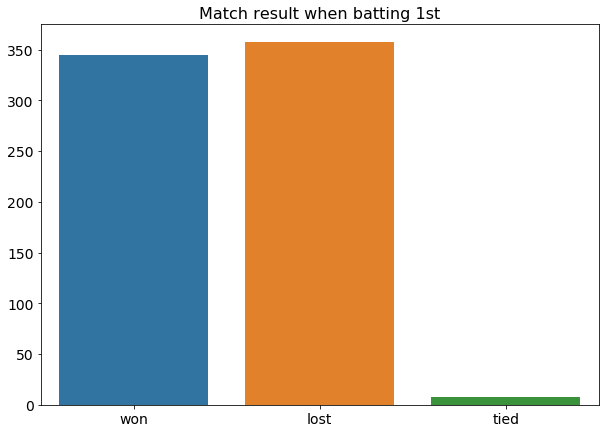

In [60]:
vis.setPlot();
sb.barplot(x=['won', 'lost','tied'], y=[((df_totals.result=="won") & (df_totals.bat=="1st")).sum(), 
                                    ((df_totals.result=="lost") & (df_totals.bat=="1st")).sum(),
                                       ((df_totals.result=="tied") & (df_totals.bat=="1st")).sum()]);
plt.title("Match result when batting 1st", fontsize=16);

Even though teams batting first score more runs on average, the number of wins does not reflect this and more matches are lost when batting first. We'll dig a little deeper into this in the next section.

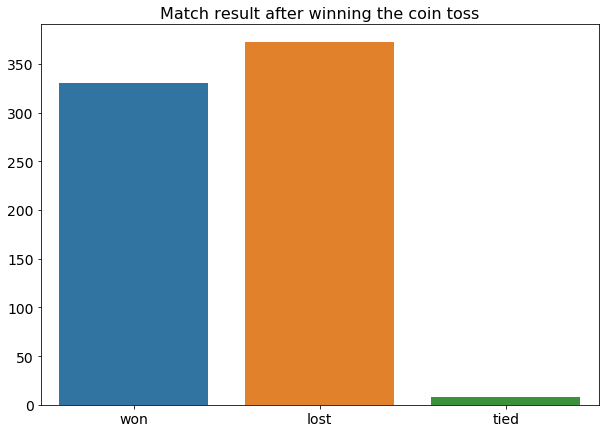

In [61]:
vis.setPlot();
sb.barplot(x=['won', 'lost', 'tied'], y=[((df_totals.result=="won") & (df_totals.toss=="won")).sum(), 
                                        ((df_totals.result=="lost") & (df_totals.toss=="won")).sum(),
                                        ((df_totals.result=="tied") & (df_totals.toss=="won")).sum()]);
plt.title("Match result after winning the coin toss", fontsize=16);

Surprisingly, more teams win the match after having lost the coin toss. In the next section we'll look into how each team performs after winning the toss, and what decisions they are most likely to make in terms of batting order.

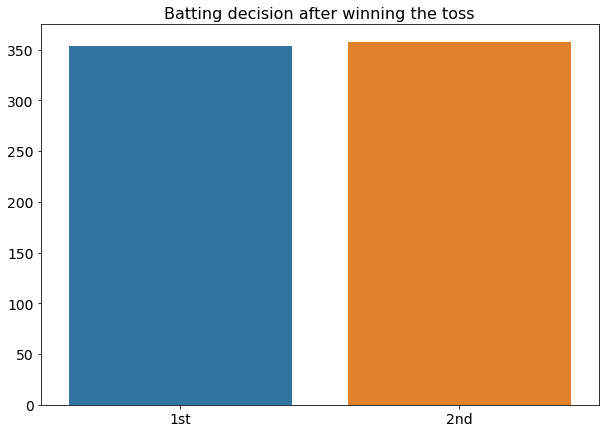

In [62]:
vis.setPlot();
sb.barplot(x=['1st', '2nd'], y=[((df_totals.bat=="1st") & (df_totals.toss=="won")).sum(), 
                                        ((df_totals.bat=="2nd") & (df_totals.toss=="won")).sum()]);

plt.title("Batting decision after winning the toss", fontsize=16);

There is very little preference for batting 1st or 2nd after having won the coin toss. We'll see in the next section if certain teams prefer to bat 1st or second after they win the toss.

Finally, we'll look at which teams are the luckiest and unluckiest at winning the coin toss.

## Multivariate
Lets now dig deeper into some of the more interesting relationships discovered in the previous section and investigate more relationships between multiple variables.

- The team batting 1st scores scores more runs on average but the team batting second wins more.
- Teams that lose the toss win more matches.

    - result margins vs time, batting first and second
    - result margins vs team, batting first or second
    - team performance (score, win, result margin) batting 1st or second
    
- Team performance over time
    - win % vs year vs team
    - score vs year vs team
    - rpo vs year vs team

we'll start by create a copy of `df_totals` so we can continue to engineer features without affecting the original data.


In [63]:
df_multi = df_totals.copy()

#### Batting order and score distributions
What effect does the batting order have on the score distributions each year?

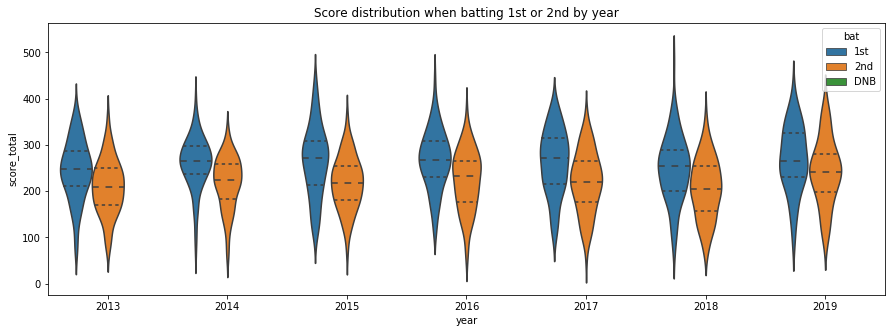

In [64]:
plt.figure(figsize=[15,5])
sb.violinplot(data=df_multi, x='year', y='score_total', hue='bat', inner='quartile');
plt.title("Score distribution when batting 1st or 2nd by year");

Here we see very similar distributions of scores across each year, with the teams batting first scoring higher than teams batting second. It is impossible for the team batting second to surpass the team batting first score by more than 6 runs because the match ends at this point.

What effect does batting order have on the distribution of wickets lost?

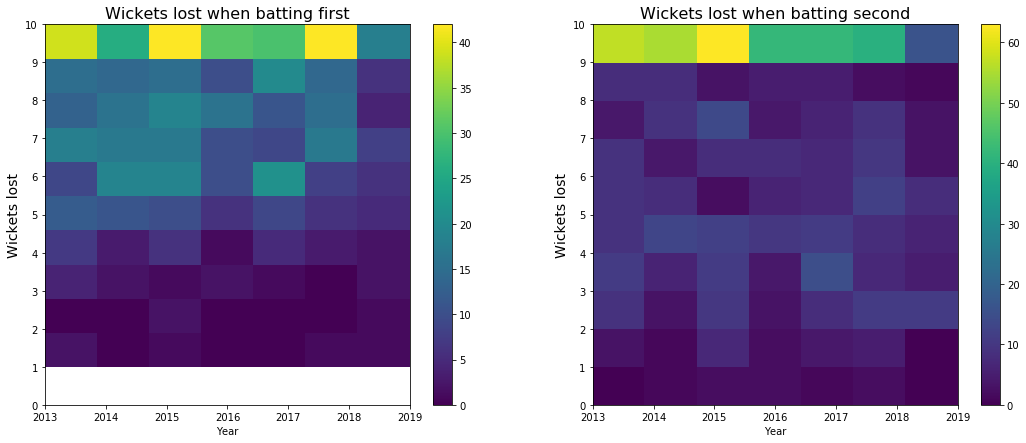

In [65]:
vis.setPlot(figsize=[18,7])

years = df_multi.year.unique()

plt.subplot(1,2,1);
plt.hist2d(data=df_multi.query('bat=="1st"'), y='wickets', x='year', bins=[7,10], cmin=0);
plt.title("Wickets lost when batting first", fontsize=16);
plt.ylabel("Wickets lost", fontsize=14);
plt.xlabel("Year");
plt.xticks(np.arange(2013,2020,1), years)
plt.yticks(np.arange(0,10.5,1), np.arange(0,11,1))
plt.colorbar();



plt.subplot(1,2,2);
plt.hist2d(data=df_multi.query('bat=="2nd"'), y='wickets', x='year', bins=[7,10], cmin=0);
plt.title("Wickets lost when batting second", fontsize=16);
plt.ylabel("Wickets lost", fontsize=14);
plt.xlabel("Year");
plt.xticks(np.arange(2013,2020,1), years)
plt.yticks(np.arange(0,10.5,1), np.arange(0,11,1))
plt.colorbar();

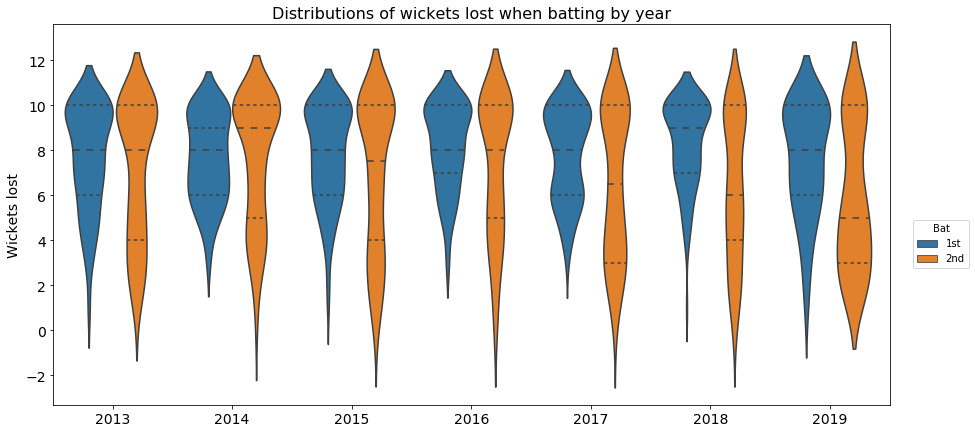

In [66]:
vis.setPlot(figsize=[15,7])
sb.violinplot(data=df_multi, x='year', y='wickets', hue='bat', inner='quartile', hue_order=['1st','2nd'])
plt.title("Distributions of wickets lost when batting by year", fontsize=16);
plt.legend(bbox_to_anchor=[1.1,0.5], title='Bat');
plt.xlabel(None);
plt.ylabel("Wickets lost");

# Return 
Both distributions are negatively skewed for all years except for 2019. Generally, for teams batting first there is a higher concentration of wickets 

The distribution of wickets lost when batting first and 2nd are skewed to the left, with the distributions when batting 2nd showing more left skew than when batting 1st. 

Lets look at the breakdown of wins vs batting order for each year.

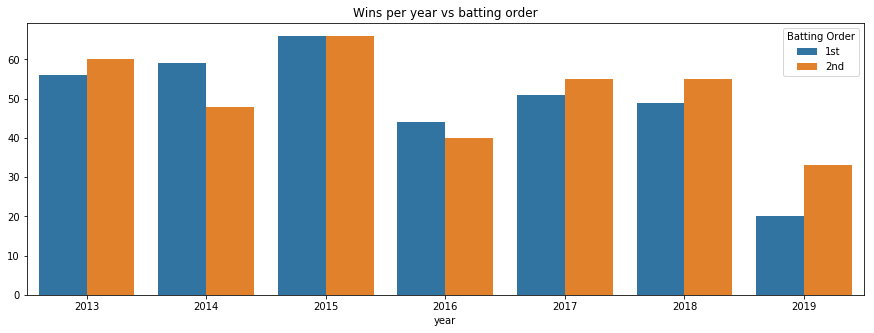

In [67]:
plt.figure(figsize=[15,5])
sb.countplot(data=df_multi[df_multi.result=="won"], x='year', hue='bat', hue_order=['1st','2nd'], dodge=True);
plt.legend(title="Batting Order");
plt.title("Wins per year vs batting order");
plt.ylabel(None);

The plot shows that there has been a switch in success of teams batting first and second. In 2014, 2015 and 2016 teams batting 1st won more matches, wheres in 2017,2018 and 2019 teams batting second have won more matches. Now lets look at how the individual teams stack up to see if we can explain the cahnge of fortune.

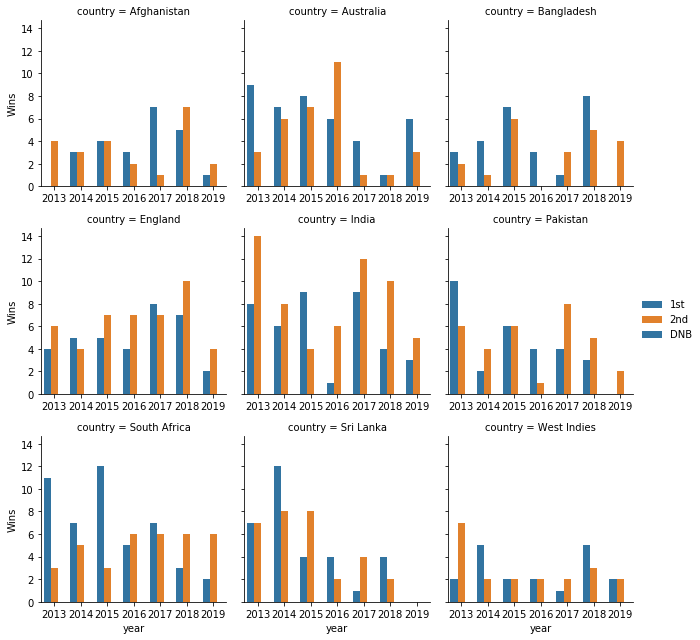

In [68]:
df_multi.year = df_multi.year.astype('category')
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi[(df_multi.result=="won")&(df_multi.country.isin(countries))], 
                 col='country', col_wrap=3, sharey=True, sharex=False, col_order=countries)

g.map(countplot, 'year', 'bat', alpha=1, palette=sb.color_palette()[0:2])
g.add_legend();
g.set_ylabels("Wins");

Here we are only considering the 9 countries taking part in this years world cup as they have played the majority of matches. England, India and Pakistan all had more success when batting 2nd in the past 3 years. Austrlia have generally always had more success when batting 1st. South Africa have had the largest switch, having significantly more success batting second in 2013, 2014 and 2015. Whilst they have won double the amount of matches batting first than second in 2018 and 2019.

Lets see which teams are most successful after winning the toss.

#### Team toss success

Firstly lets see who are the luckiest and unluckiest teams when it comes to the coin toss.

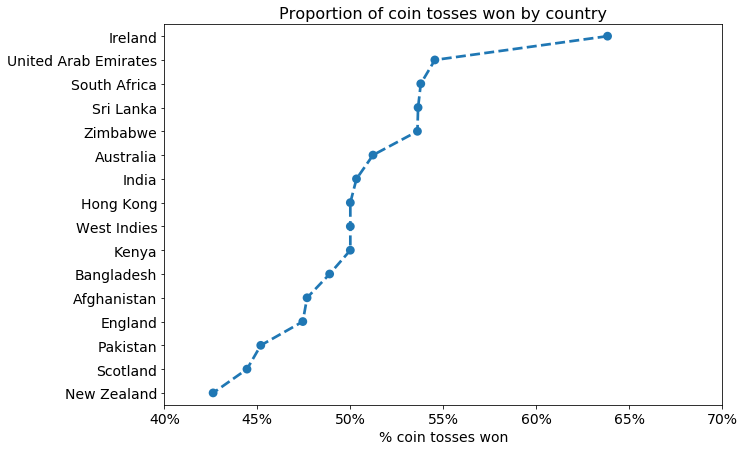

In [69]:
# Create toss dummy variable for calculating proportions
df_multi['toss_dum'] = np.where(df_multi.toss=="won", 1, 0)
order = df_multi.groupby('country').toss_dum.mean().sort_values(ascending=False)\
            .drop(['Netherlands','Papua New Guinea']).index

vis.setPlot(title="Proportion of coin tosses won by country")
sb.pointplot(data=df_multi, y='country', x='toss_dum', order=order, linestyles="--", ci=None)
ticks, labels = plt.xticks()
plt.xticks(ticks, ['{:.0f}%'.format(i*100) for i in ticks]);
plt.xlabel("% coin tosses won");
plt.ylabel("");

Its not called the luck of the Irish for no reason, they sit atop the table of most successful coin toss winners, winning nearly 65% of the time. New Zealand and Scotland are the unluckiest nation, winning less than 45% of the coint tosses. The Netherlands and Papua New Guinea were not included having participated in only 1 match each.

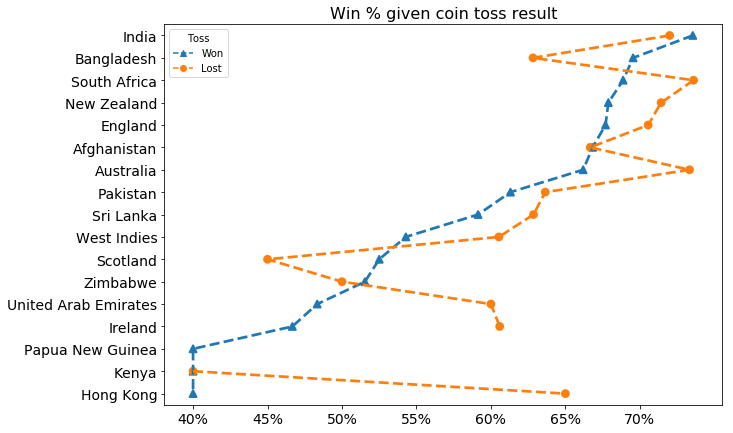

In [70]:
# Win proportion after winning toss
win_win_prop  = vis.proportions(df_multi, col1='toss', filter1='won', 
                col2='result', filter2='won', groupby='country')

# Win proportion after losing toss
lose_win_prop  = vis.proportions(df_multi, col1='toss', filter1='lost', 
                col2='result', filter2='won', groupby='country')

order=win_win_prop.index

vis.setPlot();
s1 = sb.pointplot(y=win_win_prop.index, x=win_win_prop.values, 
                  order=order,color=colour[0], markers="^", linestyles="--")
s2 = sb.pointplot(y=lose_win_prop.index, x=lose_win_prop.values, 
                  order=order, color=sb.color_palette()[1], linestyles="--")

# Creat line art for legend
l0 = mlines.Line2D([],[],color=colour[0], linestyle='--', marker='^')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='--', marker='o')

plt.legend((l0,l1), ('Won', 'Lost'), title="Toss")

ticks = np.arange(0,0.7,0.1)
lables = vis.tickLabels(ticks, pcnt=True)

plt.xticks(ticks, labels);
plt.title("Win % given coin toss result", fontsize=16);
plt.ylabel("");

India are the most successful team having won the toss, winning nearly 70% of their matches. They and Bangladesh are the only countries out of the top teams that win more matches after winning the toss. England, Australia, South Africa, New Zealand all improve their win percentages after losing the toss, with Australia and South Africa winning the highest proportion of matches after winning the toss.

We saw earlier that Ireland have won the toss 60% of the time, unfortunately for them they have only won 15% of these matches.
***
In the bivararaite analysis section we saw that marginally more teams won matches when batting second. Lets first look a the choices each team makes after winning the toss, then we'll look at the success based on their decision.

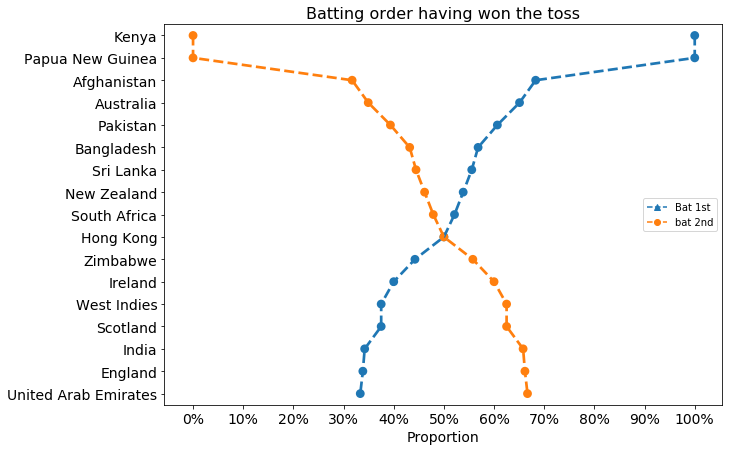

In [71]:
# Bat first after winning toss 
bat1_prop  = vis.proportions(df_multi, col1='toss', filter1='won', 
                col2='bat', filter2='1st', groupby='country', asc=False)

# Bat second after winning toss
bat2_prop  = vis.proportions(df_multi, col1='toss', filter1='won', 
                col2='bat', filter2='2nd', groupby='country', asc=False)

ticks = np.arange(0,1.1,0.1)
labels = vis.tickLabels(ticks, pcnt=True)

vis.setPlot();
sb.pointplot(x=bat1_prop.values, y=bat1_prop.index, linestyles='--', order=bat1_prop.index, color=colour[0]);
sb.pointplot(x=bat2_prop.values, y=bat2_prop.index, linestyles='--', order=bat1_prop.index, color=colour[1]);
plt.title("Batting order having won the toss", fontsize=16);
plt.xticks(ticks,labels)
plt.ylabel("");
plt.xlabel("Proportion")

# Creat line art for legend
l0 = mlines.Line2D([],[],color=colour[0], linestyle='--', marker='^')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='--', marker='o')

plt.legend((l0,l1), ('Bat 1st', 'bat 2nd'), title="", loc=5);

We can see that Afghanistan, Australia, Pakistan and Sri Lanka all significantly favour batting first having won the toss, whilst England, India, Ireland, West Indies and Zimbabwe favour bowling first having won the toss. India is the suprising one here, given that the pitches in India are normally very difficult to bat on in the 4th innings and the ball is spinning a great deal, but perhaps they enjoy that. 

What are the team win percentages given the batting order?

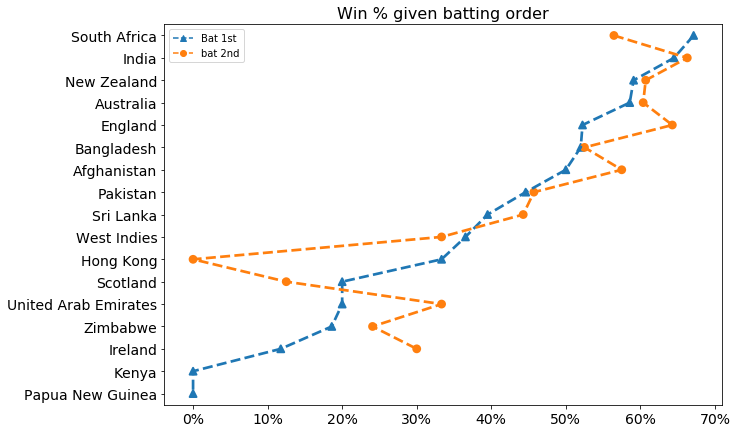

In [72]:
# Win proportion batting first
bat1_win_prop  = vis.proportions(df_multi, col1='bat', filter1='1st', 
                col2='result', filter2='won', groupby='country')

# Win proportion batting second
bat2_win_prop  = vis.proportions(df_multi, col1='bat', filter1='2nd', 
                col2='result', filter2='won', groupby='country')

order=bat1_win_prop.index

vis.setPlot();
s1 = sb.pointplot(y=bat1_win_prop.index, x=bat1_win_prop.values, 
                  order=order, color=colour[0], markers="^", linestyles="--")
s2 = sb.pointplot(y=bat2_win_prop.index, x=bat2_win_prop.values, 
                  order=order, color=sb.color_palette()[1], linestyles="--")

# Creat line art for legend
l0 = mlines.Line2D([],[],color=colour[0], linestyle='--', marker='^')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='--', marker='o')

plt.legend((l0,l1), ('Bat 1st', 'bat 2nd'), title="")


ticks = np.arange(0,0.8,0.1)
lables = vis.tickLabels(ticks, pcnt=True)

plt.xticks(ticks, labels);
plt.title("Win % given batting order", fontsize=16);
plt.ylabel("");


In most cases there is marginal difference in a teams overall win percentage when batting first or second. England have more success when batting second, winning 10% more of their matches. Afghanistan also have more success when batting second, winning 5% more of their matches. South Africa win nearly 10% more of their matched when batting first.

#### Team win % based on previous result
How does the result of the previous match affect each teams performance in their next match? 

To calculate win proportions based on the result of the previous match we make use of two functions defined in the visualize module. Each function queries a `df` by country and sorts the values by `start_date` to assess the matches in order.

In [99]:
countries=df_multi.country.unique()

win_win_props = vis.winAfterWin(df_multi, countries)
lose_win_props = vis.winAfterLoss(df_multi, countries) 

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ding/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ding/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# PICK UP HERE

In [113]:
countries = win_win_props.index
win_win_props

,1
0,
India,0.453333
Australia,0.393443
South Africa,0.358779
England,0.352941
New Zealand,0.347107
Bangladesh,0.314607
Afghanistan,0.282353
Pakistan,0.253731
Sri Lanka,0.200000


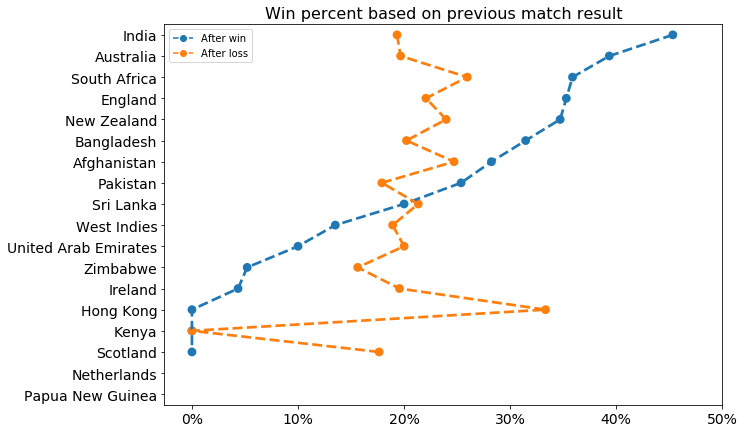

In [120]:
# Get country order
order= win_win_props.index

# Get xtick locs and labels
ticks = np.arange(0,0.6,0.1)
labels = vis.tickLabels(ticks, pcnt=True)

# Create lines for legend
l0 = mlines.Line2D([],[],color=colour[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='--', marker='o')

vis.setPlot();
sb.pointplot(x=win_win_props.values.flatten(), y=win_win_props.index, order=order, 
                color=colour[0], linestyles="--");
sb.pointplot(x=lose_win_props.values.flatten(), y=lose_win_props.index, order=order, 
                 color=colour[1], linestyles="--");
plt.title("Win percent based on previous match result", fontsize=16);
plt.ylabel("");
plt.xticks(ticks,labels);
plt.legend((l0,l1), ('After win', 'After loss'), title="");

Most teams average between 15% and 25% win after having lost their previous match. The top 8 teams all have a signifcantly higher win % after having won their previous match.

#### Score vs RPO vs Year
We saw a hockey stick shape for the overall distribution of score vs RPO earlier, what does this distribution look like for each year?

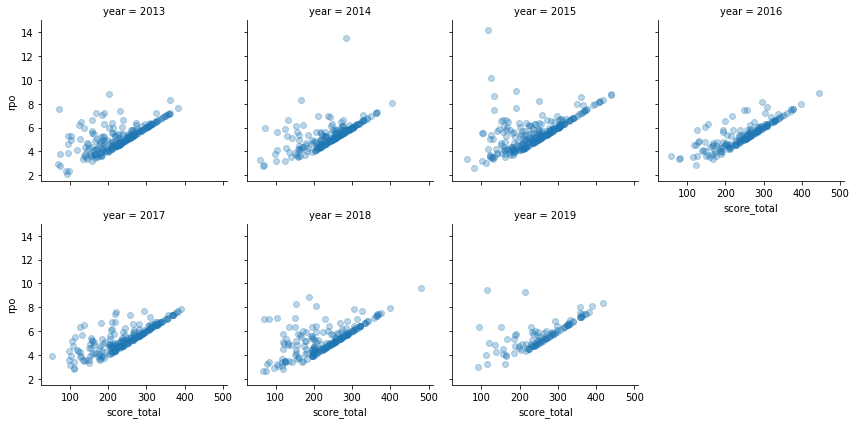

In [121]:
g = sb.FacetGrid(data=df_multi, col='year', col_wrap=4);
g.map(sb.regplot, 'score_total', 'rpo', fit_reg=False, scatter_kws={'alpha':0.3});

The relationship between score and rpo remain consistent for each year and are consistent with the hockey stick shape that we saw in the collective plot in the bivariate section. 2015 has the widest spread of points where less than 200 runs are score. We saw earlier that the most matches were played in 2015 which is the year that the previous ODI cricket world cup was held, this might explain the additional spread in the data.

#### Analysis of country score and RPO per year

Starting with average score per year for each team.

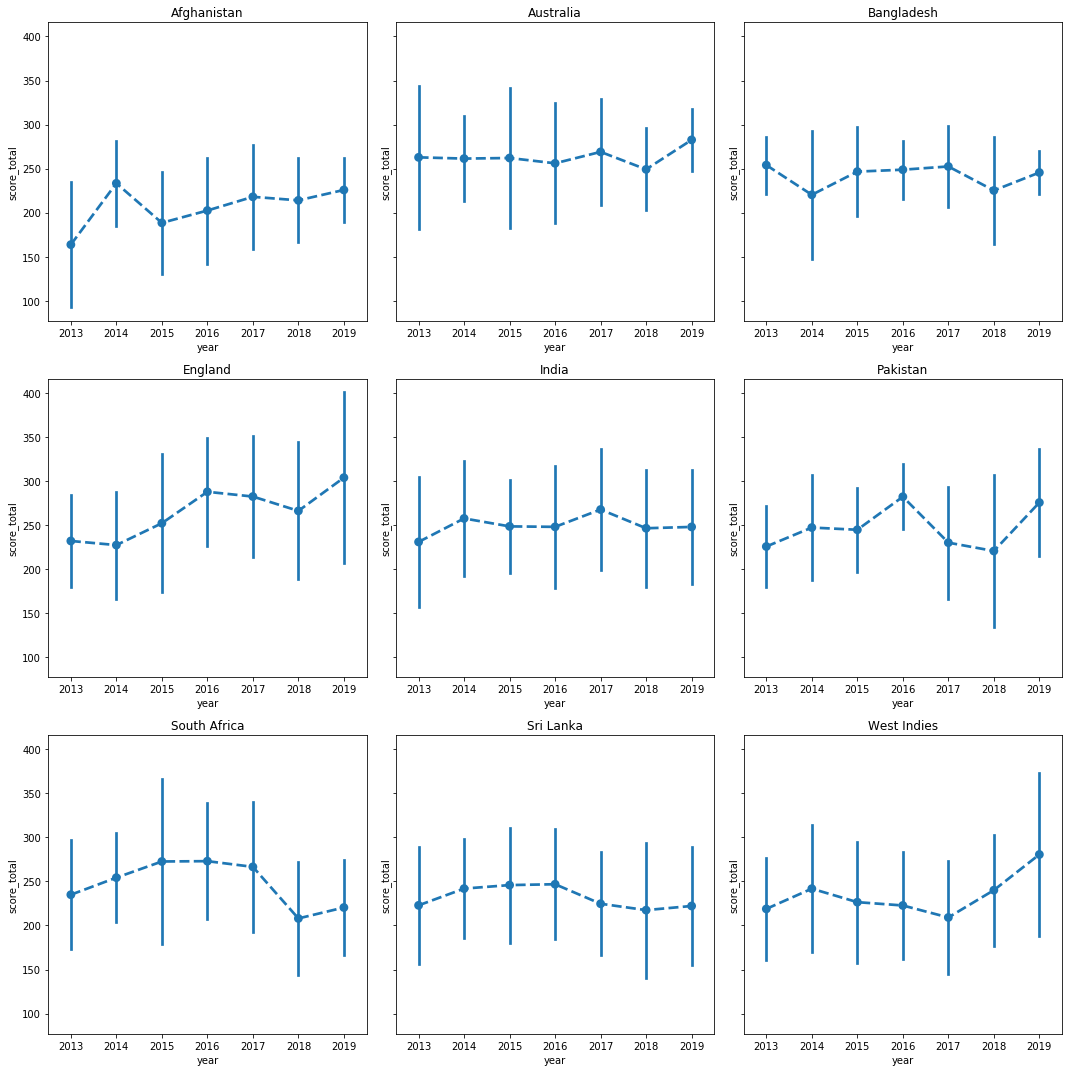

In [122]:
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

fig, axs = plt.subplots(3,3,figsize=[15,15], sharey=True)
axs = axs.flatten()

for i, c, ax in zip(np.arange(1,10,1), countries, axs):
    plt.sca(ax)
    data = df_multi[(df_multi.country==c)]
    sb.pointplot(data=data, x='year', y='score_total', ci='sd', linestyles='--', color=sb.color_palette()[0])
    plt.title(c)
    
fig.tight_layout()

Team average scores are fairly widely spread and generally oscilate around a constant mean. England have shown the most consistent increase in scoring average since 2013, while South Africa's scoring average has worsened by the most. <br><br>
We worked out previously the total score for each team might not be the best metric for measuring the teams batting performance because a team batting second will never surpass their opponents score. Below we look at the relationship between runs per over for teams when batting 1st or second, the match results and coin toss result.

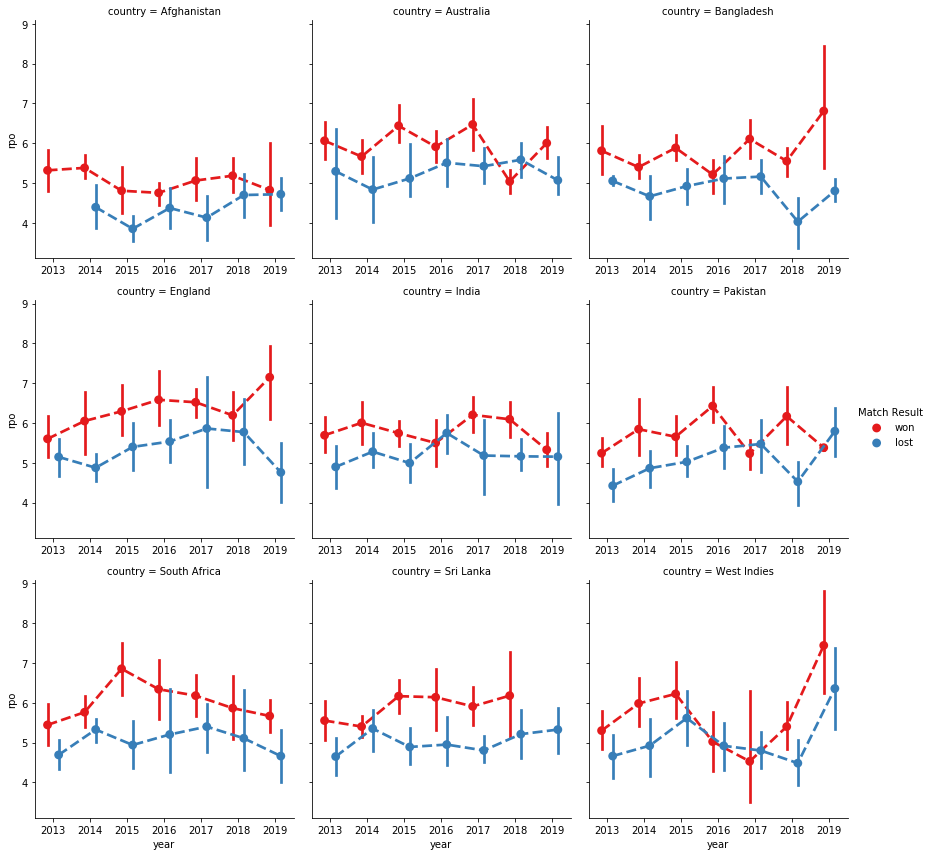

In [124]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'result', hue_order=['won','lost'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Match Result");

As one would anticipate, the average team rpo is higher when a team wins almost all of the time with some exceptions. Notably, Australia's average score in 2018 for games in which they won was lower than in games in which they had lost. Sometimes cricket is a curious sport.

We defined a funtion here to enable the `dodge` parameter to be active on the `hue` of the `FacetGrid`

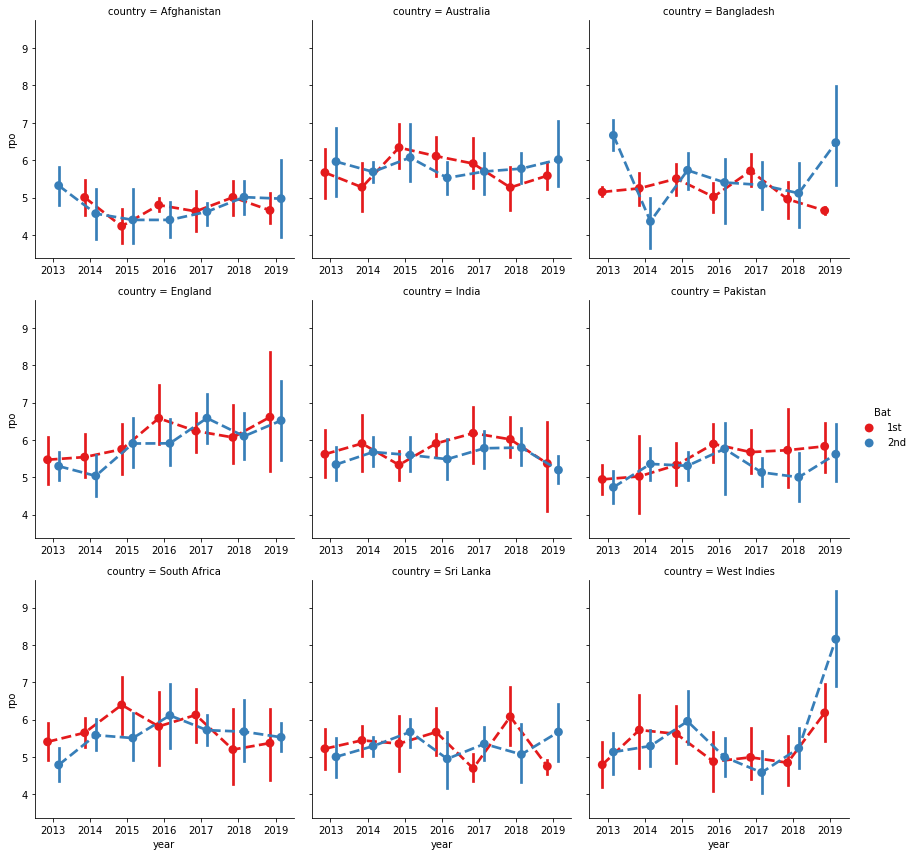

In [125]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'bat', hue_order=['1st','2nd'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Bat")

In general there is very little difference in rpo when a team is batting first or second. The West Indies have had a big jump in their average run rate batting secon in 2019, possibly due to not playing many matches yet.

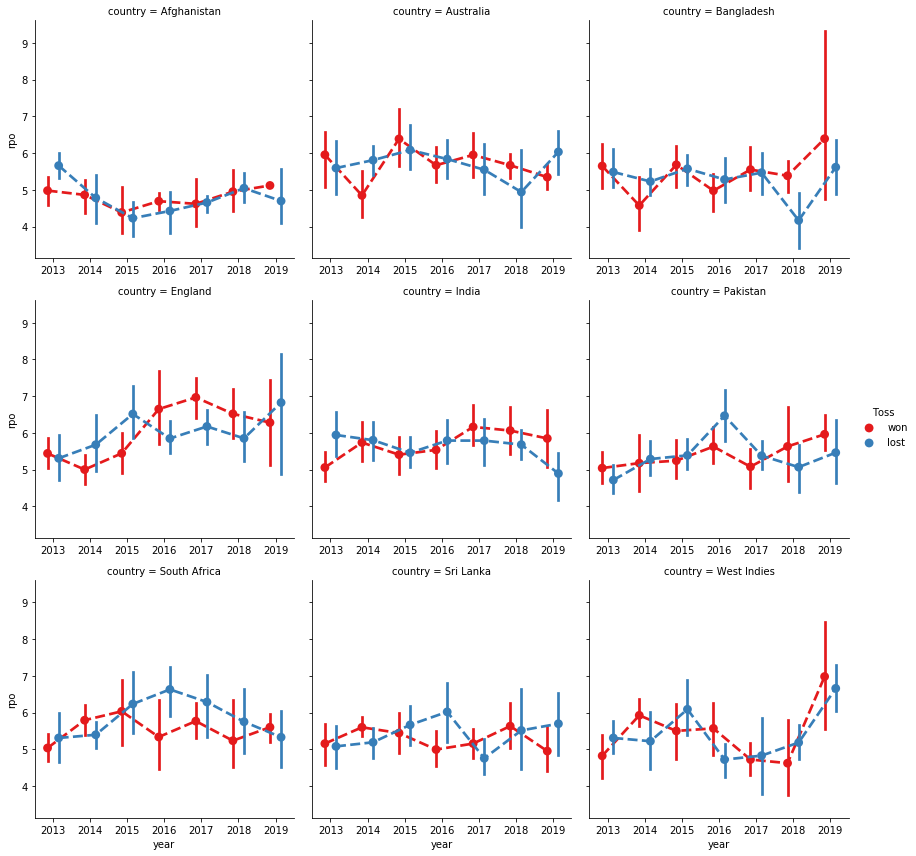

In [126]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'toss', hue_order=['won','lost'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Toss")

#### Team success relative to the ground average score
We can compare the distribution of scores for winning and losing teams more easily by overlaying their distributions.

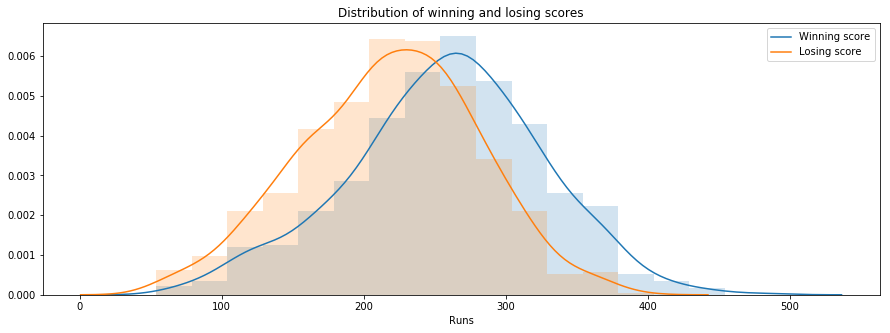

In [146]:
bins=np.arange(df_multi.score_total.min(), df_multi.score_total.max()+1, 25)

plt.figure(figsize=[15,7])
sb.distplot(df_multi[df_multi.result=="won"].score_total, bins=bins, hist_kws={'alpha':0.2});
sb.distplot(df_multi[df_multi.result=="lost"].score_total, bins=bins, hist_kws={'alpha':0.2});
plt.title("Distribution of winning and losing scores");
plt.xlabel("Runs")

l0 = mlines.Line2D([],[],color=colour[0], linestyle='-')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='-')

plt.legend((l0,l1), ['Winning score', 'Losing score']);

We can see here that there is a great deal of overlap between the scores for winning and losing teams. This makes it hard to predict what a winning score might be. We can also view these distributions as a heatmap shown below.

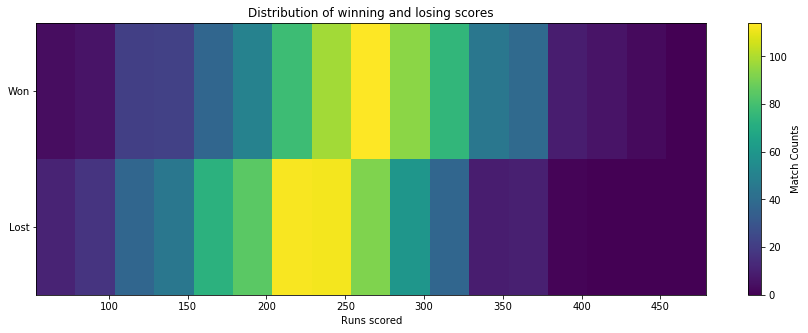

In [147]:
bins=np.arange(df.score_total.min(), df.score_total.max()+1, 25)

plt.figure(figsize=[15,5])
plt.hist2d(data=df, x='score_total', y='result', bins=(bins, (0,0.5,1)));
plt.title("Distribution of winning and losing scores");
plt.yticks((0.25,0.75),('Lost','Won'));
plt.colorbar(label='Match Counts');
plt.xlabel("Runs scored");


What do the distributions look like when we compare each score to the average score achieved on that ground?

To assess this we need to engineer a new feature `score_vs_avg` which calculates the score as a delta against the ground average calculated from the full sample games played at each ground. We can then compare the ditributions of winning and losing scores. 

In [142]:
# Remove n/r and tied results from the sample
df = df_multi[df_multi.result.isin(['won','lost'])]
# Make result a dummy variable
df.result= np.where(df.result=='won',1,0)

# Calculate score averages per ground
ground_avgs = df.groupby('ground').mean()['score_total']

# Create new feature
df['score_vs_avg'] = np.NaN

# Calculate score delta to ground average
for ground, avg in zip(ground_avgs.index, ground_avgs.values):
    df['score_vs_avg'] = np.where(df.ground == ground, df.score_total - avg, df.score_vs_avg)
    

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


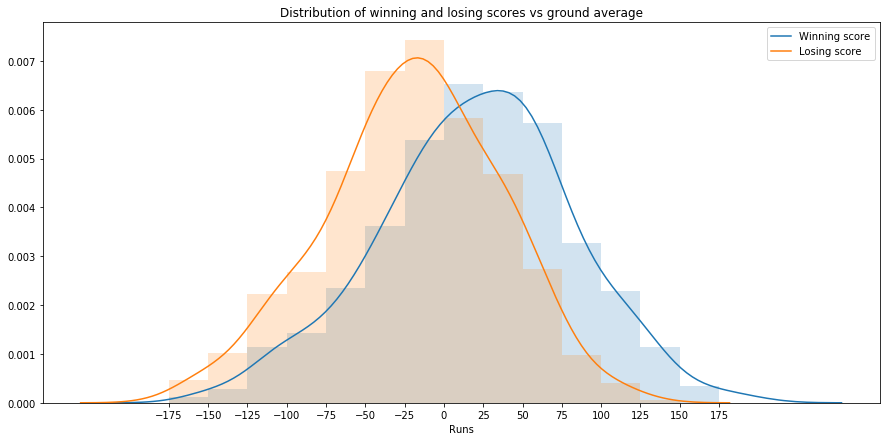

In [154]:
bins = np.arange(-175,200,25)

plt.figure(figsize=[15,7])
sb.distplot(df[df.result==1].score_vs_avg, bins=bins, hist_kws={'alpha':0.2});
sb.distplot(df[df.result==0].score_vs_avg, bins=bins, hist_kws={'alpha':0.2});
plt.title("Distribution of winning and losing scores vs ground average");
plt.xlabel("Runs")
plt.xticks(bins)

l0 = mlines.Line2D([],[],color=colour[0], linestyle='-')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='-')

plt.legend((l0,l1), ['Winning score', 'Losing score']);

The `score_vs_avg` feature separtes the two distributions more clearly than the `score_total` feature. The losing score distribution peaks around -25 runs and the winning score distribution peaks around +50 runs. 

Lets filter the dataset further to only include the scores from teams who batted 1st to avoid the left skew created by the scores of winning teams who bat 2nd.

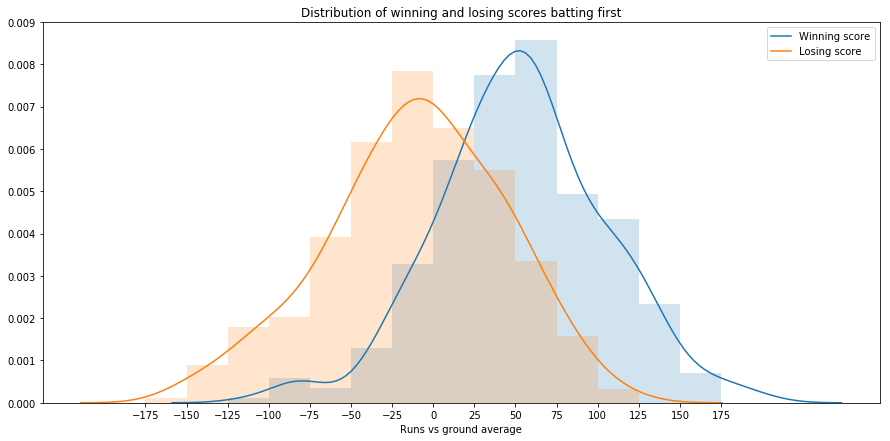

In [155]:
bins = np.arange(-175,200,25)

plt.figure(figsize=[15,7])
sb.distplot(df[(df.result==1)&(df.bat=='1st')].score_vs_avg, bins=bins, hist_kws={'alpha':0.2});
sb.distplot(df[(df.result==0)&(df.bat=='1st')].score_vs_avg, bins=bins, hist_kws={'alpha':0.2});
plt.title("Distribution of winning and losing scores batting first");
plt.xlabel("Runs vs ground average");
plt.xticks(bins)

l0 = mlines.Line2D([],[],color=colour[0], linestyle='-')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='-')

plt.legend((l0,l1), ['Winning score', 'Losing score']);

Filtering on teams that batted first only does not move the position of the peaks but it does reduce the spread of the winning score distribution and reduce the overlap. 

Lets visualise this effect using a heatmap.

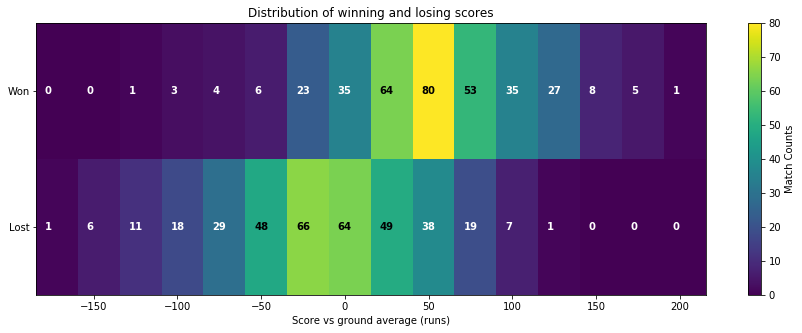

In [216]:
bins = np.arange(df.score_vs_avg.min(), df.score_vs_avg.max()+25,25)

plt.figure(figsize=[15,5])
h2, xbins, ybins, im = plt.hist2d(data=df[df.bat=='1st'], x='score_vs_avg', y='result', 
                              bins=[bins, [0,0.5,1]], cmin=0, cmap='viridis');
plt.yticks((0.25,0.75),('Lost','Won'))
plt.xlabel("Score vs ground average (runs)")
plt.colorbar(label='Match Counts');
plt.title("Distribution of winning and losing scores");

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax = plt.gca()
        if h2[j,i] > 40:
            ax.text(xbins[j]+5, ybins[i]+0.25, int(h2[j,i]), va="center", fontweight="bold")
        else:
            ax.text(xbins[j]+5, ybins[i]+0.25, int(h2[j,i]),color="w", va="center", fontweight="bold")            

The heatmap shows the separation of the distributions more clearly. If a team scores 50 runs more than the average score on that ground, they go onto win the match twice as many times. If they score between 0 and -50 runs compared to the ground average, they lose twice as many matches.

Lets compare the distributions rpo vs the ground average to see if there is a similar trend. Again, we need to engineer the new feature `rpo_vs_avg`.

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


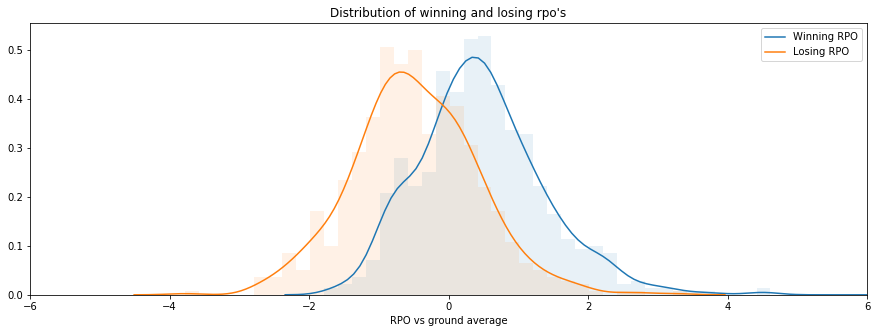

In [206]:
ground_avgs = df.groupby('ground').mean()['rpo']
df['rpo_vs_avg'] = np.NaN

for ground, avg in zip(ground_avgs.index, ground_avgs.values):
    df['rpo_vs_avg'] = np.where(df.ground == ground, df.rpo - avg, df.rpo_vs_avg)

bins = np.arange(df.rpo_vs_avg.min(),df.rpo_vs_avg.max()+0.1,0.2)

plt.figure(figsize=[15,5])
sb.distplot(df[df.result==1].rpo_vs_avg, bins=bins, hist_kws={'alpha':0.1});
sb.distplot(df[df.result==0].rpo_vs_avg, bins=bins, hist_kws={'alpha':0.1});
plt.xlim(-6,6);

plt.title("Distribution of winning and losing rpo's");
plt.xlabel("RPO vs ground average");

l0 = mlines.Line2D([],[],color=colour[0], linestyle='-')
l1 = mlines.Line2D([],[],color=colour[1], linestyle='-')

plt.legend((l0,l1), ['Winning RPO', 'Losing RPO']);

We see a simlar pattern of distributions when we compare the rpo vs the ground average rpo.

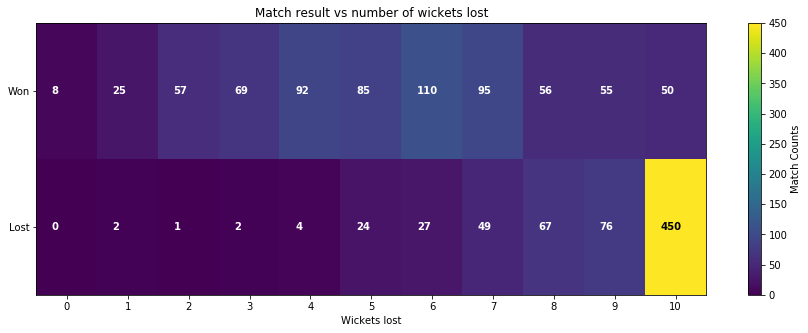

In [227]:
bins = np.arange(0,12,1)

plt.figure(figsize=[15,5])
h2, xbins, ybins, im = plt.hist2d(data=df, x='wickets', y='result', bins=[bins, [0,0.5,1]], 
                                  cmin=0, cmap='viridis');
plt.title("Match result vs number of wickets lost")
plt.xlabel("Wickets lost")
plt.colorbar(label='Match Counts');
plt.yticks((0.25,0.75),('Lost','Won'));
plt.xticks(np.arange(0.5,11,1), bins[:-1])


for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax = plt.gca()
        if h2[j,i] > 400:
            ax.text(xbins[j]+0.25, ybins[i]+0.25, int(h2[j,i]), va="center", fontweight="bold")
        else:
            ax.text(xbins[j]+0.25, ybins[i]+0.25, int(h2[j,i]),color="w", va="center", fontweight="bold") 

Teams that lose all 10 wickets in there innings are 9 times more likely to lose the match. Teams who lose less than 5 wickets rarely lose the match. The distribution of wickets lost for teams who won the match is left skewed but much less so than the distribution of teams who lost the match.